In [ ]:
from google.colab import files
files.upload('/root/.config/kaggle')

Saving kaggle.json to /root/.config/kaggle/kaggle.json


{'/root/.config/kaggle/kaggle.json': b'{"username":"geertvanderwal","key":"ef3fffac3385c3433d2a0059be82ac58"}'}

In [ ]:
!ls /root/.config/kaggle

ls: cannot access '/root/.config/kaggle': No such file or directory


In [ ]:
!pip install kaggle


In [ ]:
# Install packages if needed with this command:
#!pip install -r requirements.txt
import os

import pandas as pd
import tensorflow as tf
import kaggle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


import seaborn as sns
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Resizing, Lambda, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

from itertools import cycle
from sklearn.metrics import RocCurveDisplay
import torch





# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)



In [ ]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset',
                                    path=data_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zeyad1mashhour/driver-inattention-detection-dataset


In [ ]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f:
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]),
                                label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f:
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]),
                               label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f:
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


In [ ]:
class_indices = train_data.class_indices
print("Class Indices:", class_indices)

Class Indices: {'DangerousDriving': 0, 'Distracted': 1, 'Drinking': 2, 'SafeDriving': 3, 'SleepyDriving': 4, 'Yawn': 5}


Class 'DangerousDriving': 3732 samples
Class 'Distracted': 1676 samples
Class 'Drinking': 347 samples
Class 'SafeDriving': 4969 samples
Class 'SleepyDriving': 785 samples
Class 'Yawn': 439 samples


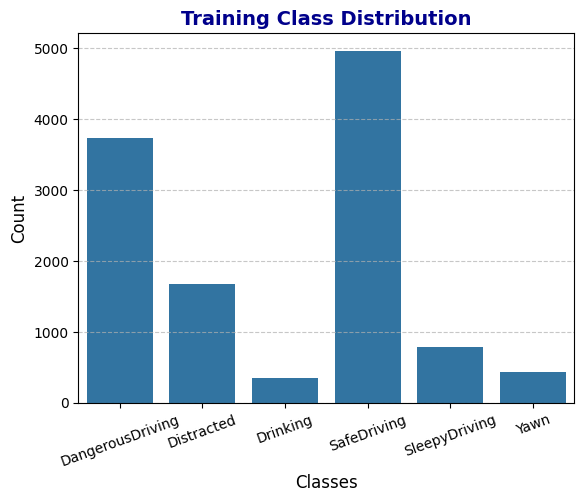

Class 'DangerousDriving': 609 samples
Class 'Distracted': 252 samples
Class 'Drinking': 56 samples
Class 'SafeDriving': 799 samples
Class 'SleepyDriving': 125 samples
Class 'Yawn': 81 samples


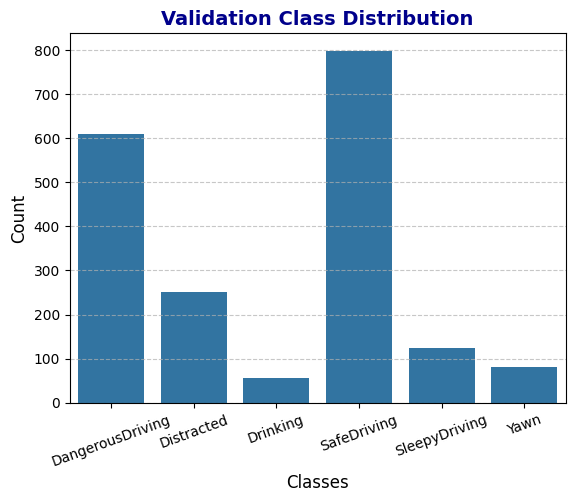

Class 'DangerousDriving': 301 samples
Class 'Distracted': 152 samples
Class 'Drinking': 25 samples
Class 'SafeDriving': 412 samples
Class 'SleepyDriving': 69 samples
Class 'Yawn': 26 samples


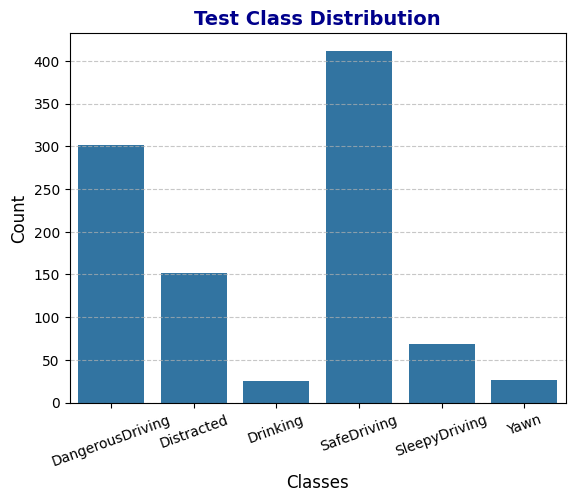

Class 'DangerousDriving': 4642 samples
Class 'Distracted': 2080 samples
Class 'Drinking': 428 samples
Class 'SafeDriving': 6180 samples
Class 'SleepyDriving': 979 samples
Class 'Yawn': 546 samples


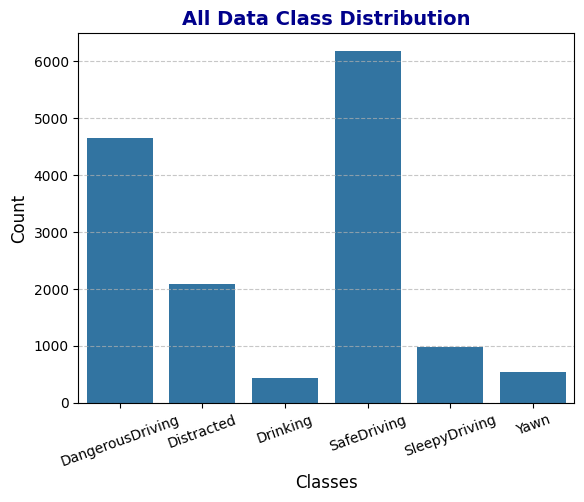

In [ ]:
# Function for plotting the data distribution
def plot_class_distribution(data, title):
    counts = sum(np.bincount(d.classes) for d in data)
    class_names = list(data[0].class_indices.keys())


    for class_name, count in zip(class_names, counts):
        print(f"Class '{class_name}': {count} samples")


    sns.barplot(x=class_names, y=counts)
    plt.title(title, fontsize=14, fontweight='bold', color='darkblue')
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    plt.xticks(rotation=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution([train_data], 'Training Class Distribution')
plot_class_distribution([val_data], 'Validation Class Distribution')
plot_class_distribution([test_data], 'Test Class Distribution')
plot_class_distribution([train_data, val_data, test_data], 'All Data Class Distribution')



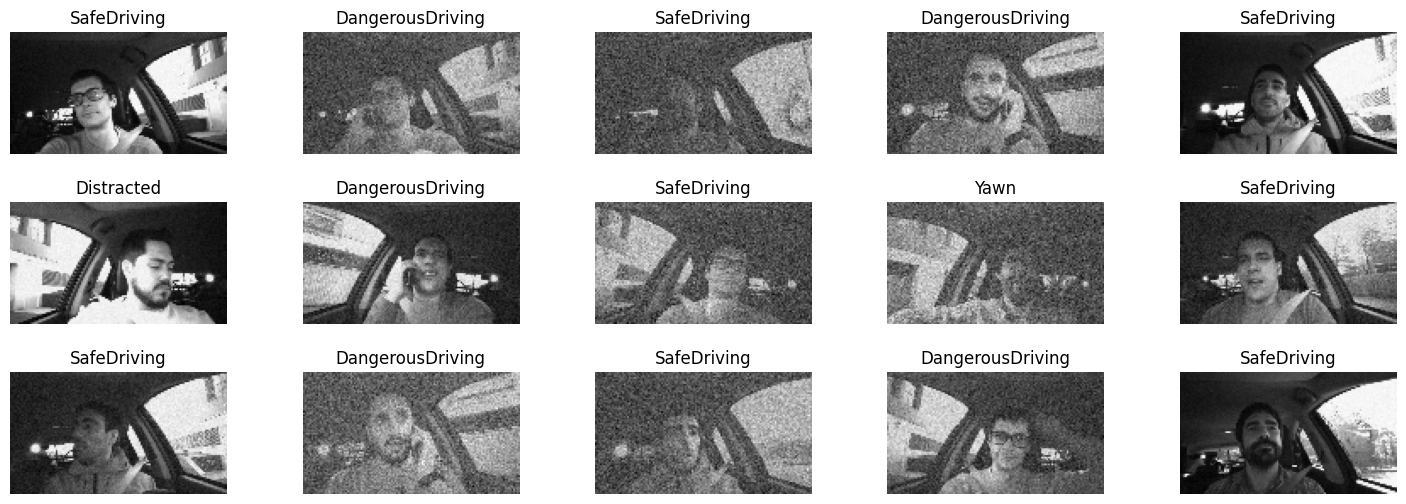

In [ ]:
# Function to randomly plot 15 samples of the data
def plot_sample_images(data, num_samples):

    class_names = list(data.class_indices)

    plt.figure(figsize=(18, 6))

    for i, (img, label) in zip(range(num_samples), data):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(img[0].squeeze(), cmap='gray')
        ax.set_title(class_names[np.argmax(label[0])], fontsize=12)
        ax.axis("off")

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

plot_sample_images(train_data, 15)


In [ ]:
#Build the baseline model
base_model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(6, activation='softmax')
])

# Print model summary
base_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the baseline model
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the baseline model
baseline_history = base_model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 70s 181ms/step - accuracy: 0.4158 - loss: 1.4250 - val_accuracy: 0.6009 - val_loss: 1.0034
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.6171 - loss: 0.9851 - val_accuracy: 0.7175 - val_loss: 0.7895
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.6963 - loss: 0.8082 - val_accuracy: 0.7544 - val_loss: 0.7034
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.7423 - loss: 0.7016 - val_accuracy: 0.7128 - val_loss: 0.7640
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - accuracy: 0.7561 - loss: 0.6600 - val_accuracy: 0.7497 - val_loss: 0.6865
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 67s 179ms/step - accuracy: 0.7727 - loss: 0.6313 - val_accuracy: 0.7856 - val_loss: 0.6110
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.7893 - loss: 0.5760 - val_accuracy: 0.8174 - val_loss: 0.5664
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.7995 - loss: 0

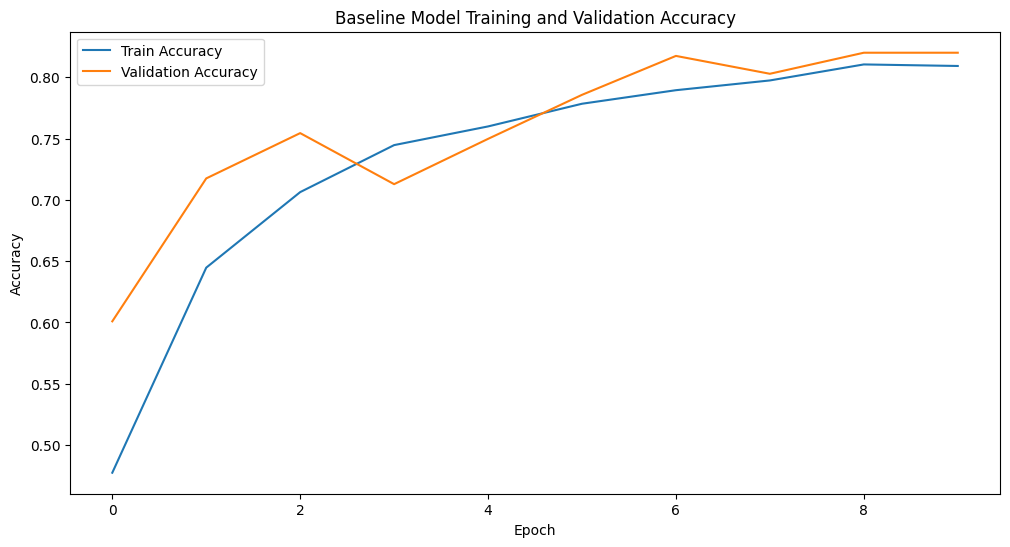

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

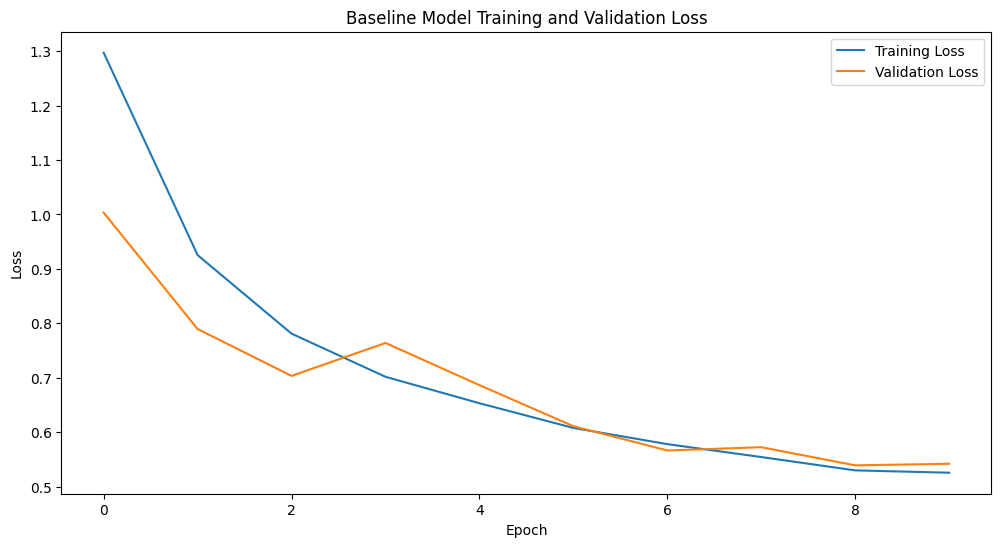

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step


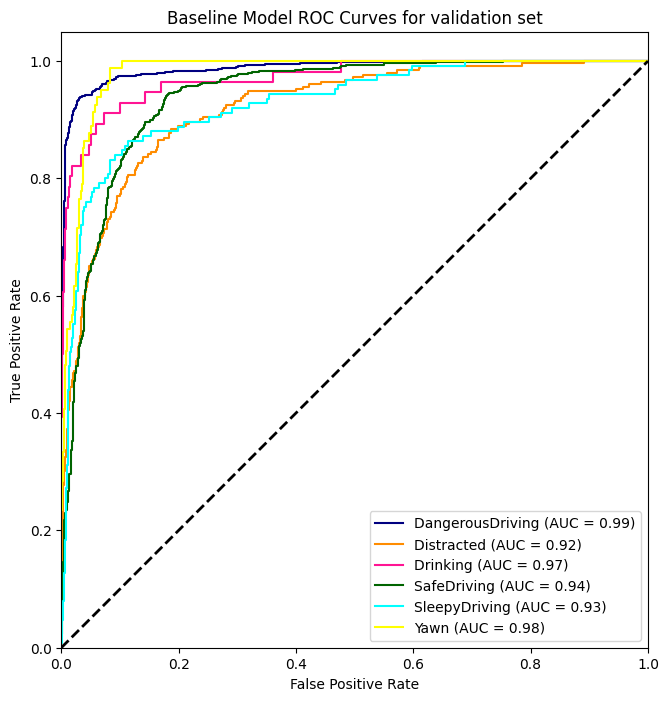

In [ ]:
# Plot ROC curve for validation set
# Followed https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html & https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_pred_val = base_model.predict(val_data)

y_train = train_data.classes
y_val = val_data.classes
n_classes = len(val_data.class_indices)

y_onehot_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
class_labels = list(val_data.class_indices.keys())


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_pred_val[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model ROC Curves for validation set')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


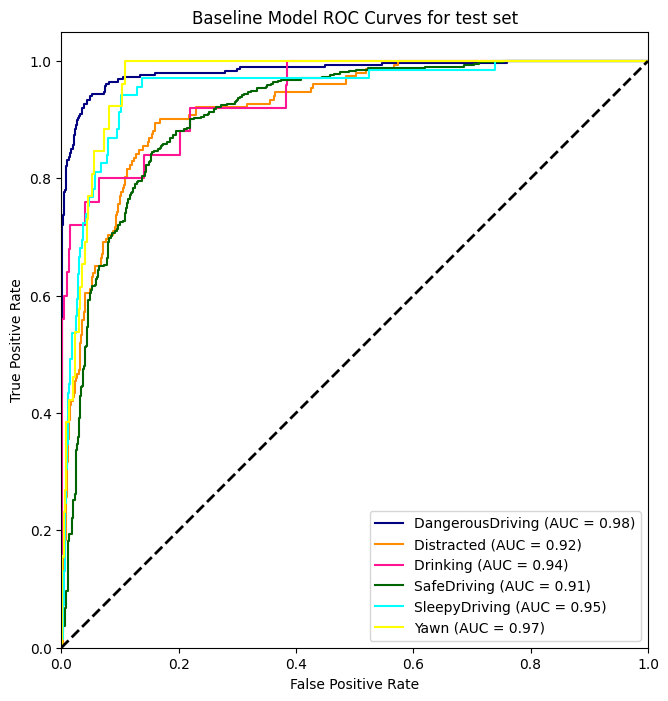

In [ ]:
# Plot ROC curve for test set
y_pred_test = base_model.predict(test_data)

y_test = test_data.classes
n_classes = len(test_data.class_indices)

y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model ROC Curves for test set')
plt.legend(loc="lower right")
plt.show()

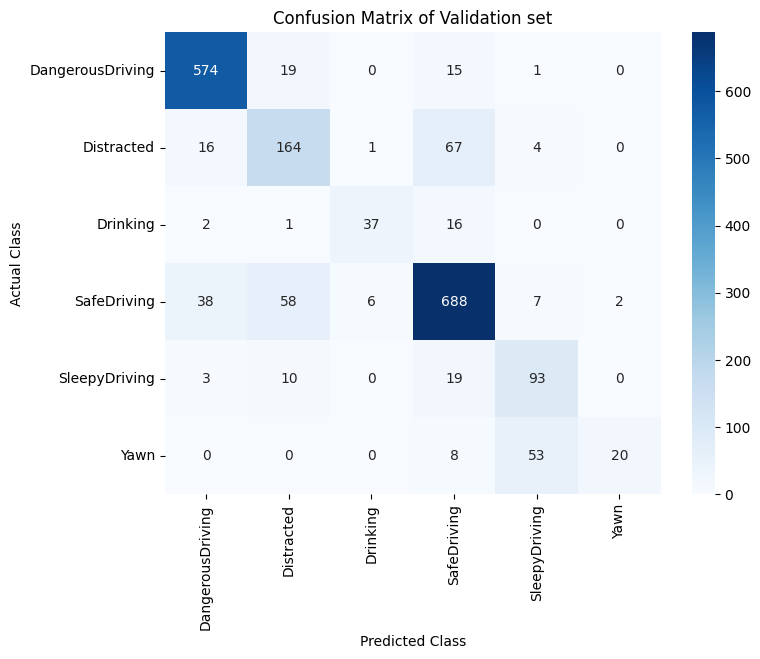

In [ ]:
# Plot confusion matrix for validation set
# Followed https://seaborn.pydata.org/generated/seaborn.heatmap.html
y_pred_classes_val = np.argmax(y_pred_val, axis=1)

y_true_val  = val_data.classes

cm = confusion_matrix(y_true_val, y_pred_classes_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title('Confusion Matrix of Validation set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

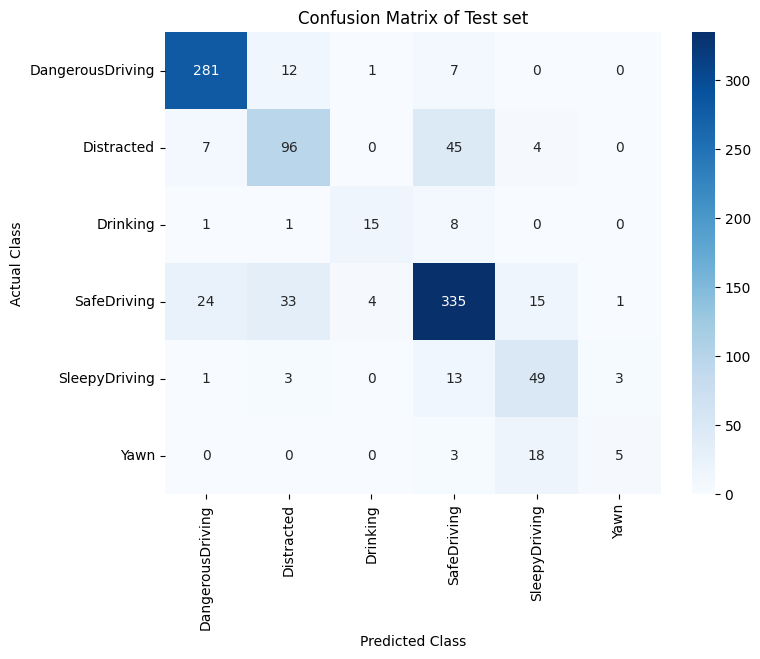

In [ ]:
# Plot confusion matrix for test set
y_pred_classes = np.argmax(y_pred_test, axis=1)

y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Performance measures for validation set
# Followed https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys()))
print(report_val)

                  precision    recall  f1-score   support

DangerousDriving       0.91      0.94      0.92       609
      Distracted       0.65      0.65      0.65       252
        Drinking       0.84      0.66      0.74        56
     SafeDriving       0.85      0.86      0.85       799
   SleepyDriving       0.59      0.74      0.66       125
            Yawn       0.91      0.25      0.39        81

        accuracy                           0.82      1922
       macro avg       0.79      0.68      0.70      1922
    weighted avg       0.83      0.82      0.81      1922



In [ ]:
# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print(report_test)

                  precision    recall  f1-score   support

DangerousDriving       0.89      0.93      0.91       301
      Distracted       0.66      0.63      0.65       152
        Drinking       0.75      0.60      0.67        25
     SafeDriving       0.82      0.81      0.81       412
   SleepyDriving       0.57      0.71      0.63        69
            Yawn       0.56      0.19      0.29        26

        accuracy                           0.79       985
       macro avg       0.71      0.65      0.66       985
    weighted avg       0.79      0.79      0.79       985



# Preprocessing of images tried for improved model

**Class imbalance:** We tried to address the data imbalance with class weights adjustment: Modifying the loss function to assign higher weights to the minority class, ensuring the model pays more attention to underrepresented categories. This only seemed to Worsen the model compared to the baseline (Best val_accuracy: 0.4563). This is why we didnt use it for the improvement of our model.

**Data augmentation** is a technique used to artificially increase the size and diversity of a dataset by applying transformations to existing images. We tried using this on our model, but it got worse results compared to the baseline model (best val_accuracy: 0.5791). This is why we also didnt use it for our model improvement

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# dealing with class imbalance: Compute initial class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.5335834226509467, 1: 1.1881463802704852, 2: 5.738712776176753, 3: 0.4007513248809284, 4: 2.5367303609341825, 5: 4.5360668185269555}


In [ ]:
# Compile the baseline model
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the baseline model
baseline_history = base_model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data, class_weight=class_weights)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 214ms/step - accuracy: 0.2958 - loss: 1.4822 - val_accuracy: 0.3829 - val_loss: 1.5235
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 225ms/step - accuracy: 0.2930 - loss: 1.4754 - val_accuracy: 0.3897 - val_loss: 1.4823
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 217ms/step - accuracy: 0.3100 - loss: 1.4243 - val_accuracy: 0.3491 - val_loss: 1.6453
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 212ms/step - accuracy: 0.3111 - loss: 1.4316 - val_accuracy: 0.4100 - val_loss: 1.3887
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.3323 - loss: 1.4022 - val_accuracy: 0.3502 - val_loss: 1.4600
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.3137 - loss: 1.4354 - val_accuracy: 0.3944 - val_loss: 1.5178
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 212ms/step - accuracy: 0.3184 - loss: 1.3978 - val_accuracy: 0.3590 - val_loss: 1.5278
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - accuracy: 0.3052 - loss: 1

In [ ]:
# Niya: Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Distorts perspective
    zoom_range=0.2,  # Zoom in on images
    horizontal_flip=True, # Mirror image
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_augmented = train_datagen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = val_datagen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = test_datagen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')




Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


In [ ]:
improved_history = improved_model.fit(
    train_data_augmented,
    epochs=15,
    batch_size=32,
    validation_data=val_data,
    callbacks=[reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 394s 911ms/step - accuracy: 0.3623 - loss: 1.9563 - val_accuracy: 0.3169 - val_loss: 9.9199 - learning_rate: 3.0000e-04
Epoch 2/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 332s 888ms/step - accuracy: 0.4321 - loss: 1.5242 - val_accuracy: 0.3580 - val_loss: 1.7705 - learning_rate: 3.0000e-04
Epoch 3/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 347s 927ms/step - accuracy: 0.4400 - loss: 1.4906 - val_accuracy: 0.3658 - val_loss: 1.6130 - learning_rate: 3.0000e-04
Epoch 4/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 342s 913ms/step - accuracy: 0.4581 - loss: 1.4565 - val_accuracy: 0.4501 - val_loss: 1.4201 - learning_rate: 3.0000e-04
Epoch 5/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 336s 898ms/step - accuracy: 0.4723 - loss: 1.4138 - val_accuracy: 0.4605 - val_loss: 1.4087 - learning_rate: 3.0000e-04
Epoch 6/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 379s 890ms/step - accuracy: 0.4797 - loss: 1.3975 - val_accuracy: 0.5078 - val_loss: 1.2780 - learning_rate: 3.0000e-04
Epoch 7/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 

# Hypertune at least six hyperparamteres


*   Addition of more layers
*   Alter filter sizes and numbers
*   Adjust the activation functions

*   Fine-tune the learning rate with different optimizers
*   Change number of neurons or dense layers







In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


Hyperparameter tuning Lisa


In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.activations import relu, tanh, sigmoid

def create_model(trial):
    num_filters = trial.suggest_int('num_filters', 8, 32, step=8)
    kernel_size = trial.suggest_categorical('kernel_size', [(3,3), (5,5)])
    dense_units = trial.suggest_int('dense_units', 10, 100, step=10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    optimizer_choice = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    activation_function = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh', 'sigmoid'])

    # Build model based on baseline model
    model = Sequential([
        Conv2D(num_filters, kernel_size, activation='relu', input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2,2)),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(6, activation='softmax')
    ])

    # Choose optimizers based on the trial
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    x_train, y_train = next(train_data)
    x_val, y_val = next(val_data)

    history = model.fit(x_train, y_train, epochs=5, batch_size=128,
                        validation_data=(x_val, y_val), verbose=0)
    return history.history['val_accuracy'][-1]

# Using Optuna to optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_trial.params)

In [ ]:
# best hyperparameters obtained during tuning were: number of filters: 8, kernel size: (5,5), dense units: 100, learning rate: 0.001240148626984186, optimizer: RMSprop, and activation function: Leaky ReLU. The obtained accuracy was 0.9044 on the test set and 0.8616 on the validation set.# result: accuracy= 0.9213, loss= 0.2472, val_accuracy: 0.8933, val_loss: 0.3348
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam, RMSprop

num_filters = 24
kernel_size = (5,5)
dense_units = 30
learning_rate = 0.0005691788367894136
optimizer_choice = 'Adam'
activation_function = 'tanh'

# the optimized model
opt_model = Sequential()
opt_model.add(Conv2D(num_filters, kernel_size, input_shape=(img_height, img_width, 1)))

if activation_function == 'leaky_relu':
    opt_model.add(LeakyReLU(alpha=0.1))
else:
    opt_model.add(Activation(activation_function))

opt_model.add(MaxPooling2D((2, 2)))
opt_model.add(Conv2D(num_filters, kernel_size, activation=activation_function))
opt_model.add(MaxPooling2D((2, 2)))
opt_model.add(Conv2D(num_filters, kernel_size, activation=activation_function))
opt_model.add(MaxPooling2D((2, 2)))
opt_model.add(Flatten())
opt_model.add(Dense(dense_units, activation=activation_function))
opt_model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
opt_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the baseline model
opt_history = opt_model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

In [ ]:
# Plot training and validation accuracy optimized model
plt.figure(figsize=(12, 6))
plt.plot(opt_history.history['accuracy'], label='Train Accuracy')
plt.plot(opt_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot training and validation loss optimized model
plt.figure(figsize=(12, 6))
plt.plot(opt_history.history['loss'], label='Training Loss')
plt.plot(opt_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**The improved_model_v3** enhanced feature learning by increasing filters (32 to 256), adding a fourth convolutional layer, and using a 5x5 kernel for better extraction. Batch normalization stabilized training, while dropout and L2 regularization reduced overfitting. Early stopping was implemented, and epochs increased from 10 to 30, with no gains at 40. SGD with momentum (0.9) replaced Adam for better generalization. These changes boosted performance to 92.3% training accuracy, 90.9% validation accuracy, and 91.37% test accuracy, reducing misclassifications in critical categories and improving class separability in ROC curves.

T

In [ ]:
# Improved model v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the improved model v3
improved_model_v3 = Sequential()

# First Conv Block (More filters, Larger Kernel)
improved_model_v3.add(Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(img_height, img_width, 1)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Second Conv Block
improved_model_v3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Third Conv Block
improved_model_v3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Fourth Conv Block (Extra Layer)
improved_model_v3.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Flattening
improved_model_v3.add(Flatten())

# Fully Connected Layers
improved_model_v3.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(Dropout(0.5))

improved_model_v3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(Dropout(0.5))

improved_model_v3.add(Dense(len(train_data.class_indices), activation='softmax'))

# Compile the model with SGD + Momentum
improved_model_v3.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Early Stopping (prevents overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the improved model v3
improved_history_v3 = improved_model_v3.fit(train_data,
                                            epochs=30,
                                            validation_data=val_data,
                                            batch_size=32,
                                            callbacks=[early_stopping])


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.5157 - loss: 1.4050 - val_accuracy: 0.6826 - val_loss: 1.1197
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.6376 - loss: 1.1402 - val_accuracy: 0.7549 - val_loss: 0.8475
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 374s 989ms/step - accuracy: 0.7108 - loss: 0.9621 - val_accuracy: 0.7799 - val_loss: 0.7829
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.7537 - loss: 0.8472 - val_accuracy: 0.7919 - val_loss: 0.7234
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.7737 - loss: 0.8028 - val_accuracy: 0.8075 - val_loss: 0.7150
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7959 - loss: 0.7314 - val_accuracy: 0.8163 - val_loss: 0.6760
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.8110 - loss: 0.6891 - val_accuracy: 0.8533 - val_loss: 0.6093
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.8286 - loss: 0.6603 - val_a

In [ ]:
# Improved model v3 evaluation
test_loss, test_acc = improved_model_v3.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.9109 - loss: 0.4388
Test Accuracy: 0.913705587387085
Test Loss: 0.45744094252586365


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step


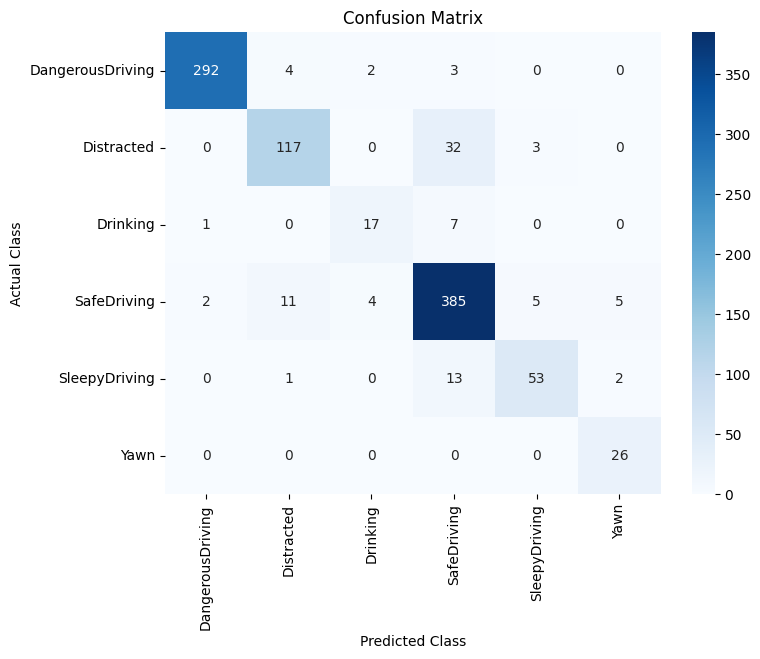

In [ ]:
# Plot confusion matrix for test set
y_pred = improved_model_v3.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Performance measures for test set
report = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print(report)

                  precision    recall  f1-score   support

DangerousDriving       0.99      0.97      0.98       301
      Distracted       0.88      0.77      0.82       152
        Drinking       0.74      0.68      0.71        25
     SafeDriving       0.88      0.93      0.90       412
   SleepyDriving       0.87      0.77      0.82        69
            Yawn       0.79      1.00      0.88        26

        accuracy                           0.90       985
       macro avg       0.86      0.85      0.85       985
    weighted avg       0.90      0.90      0.90       985



31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step


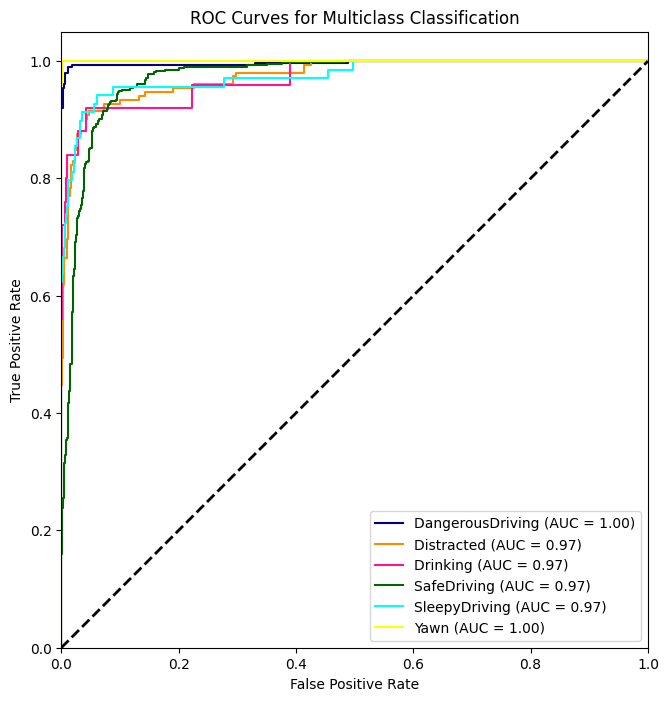

In [ ]:
# Plot ROC curve for test set
y_pred_test = improved_model_v3.predict(test_data)

y_test = test_data.classes
n_classes = len(test_data.class_indices)

y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Lily : improved model v3 with more epochs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the improved model v3
improved_model_v3 = Sequential()

# First Conv Block (More filters, Larger Kernel)
improved_model_v3.add(Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(img_height, img_width, 1)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Second Conv Block
improved_model_v3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Third Conv Block
improved_model_v3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Fourth Conv Block (Extra Layer)
improved_model_v3.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(BatchNormalization())
improved_model_v3.add(MaxPooling2D((2, 2)))

# Flattening
improved_model_v3.add(Flatten())

# Fully Connected Layers
improved_model_v3.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(Dropout(0.5))

improved_model_v3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
improved_model_v3.add(Dropout(0.5))

improved_model_v3.add(Dense(len(train_data.class_indices), activation='softmax'))

# Compile the model with SGD + Momentum
improved_model_v3.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Early Stopping (prevents overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the improved model v3 with more epochs
improved_history_v3 = improved_model_v3.fit(train_data,
                                            epochs=40,
                                            validation_data=val_data,
                                            batch_size=32,
                                            callbacks=[early_stopping])


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.3998 - loss: 1.9931 - val_accuracy: 0.5552 - val_loss: 1.2717
Epoch 2/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 358s 956ms/step - accuracy: 0.5533 - loss: 1.3128 - val_accuracy: 0.7097 - val_loss: 0.9714
Epoch 3/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 359s 957ms/step - accuracy: 0.6689 - loss: 1.0686 - val_accuracy: 0.8101 - val_loss: 0.7663
Epoch 4/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 356s 949ms/step - accuracy: 0.7365 - loss: 0.9125 - val_accuracy: 0.7945 - val_loss: 0.7133
Epoch 5/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 391s 976ms/step - accuracy: 0.7697 - loss: 0.8145 - val_accuracy: 0.7950 - val_loss: 0.7487
Epoch 6/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 359s 959ms/step - accuracy: 0.7867 - loss: 0.7917 - val_accuracy: 0.7737 - val_loss: 0.7657
Epoch 7/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.8051 - loss: 0.7226 - val_accuracy: 0.8195 - val_loss: 0.6634
Epoch 8/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 370s 976ms/step - accuracy: 0.8124 - loss: 0.7009 - v

In [ ]:
# Improved model v3 evaluation
test_loss, test_acc = improved_model_v3.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9156 - loss: 0.4635
Test Accuracy: 0.9096446633338928
Test Loss: 0.4827491044998169


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


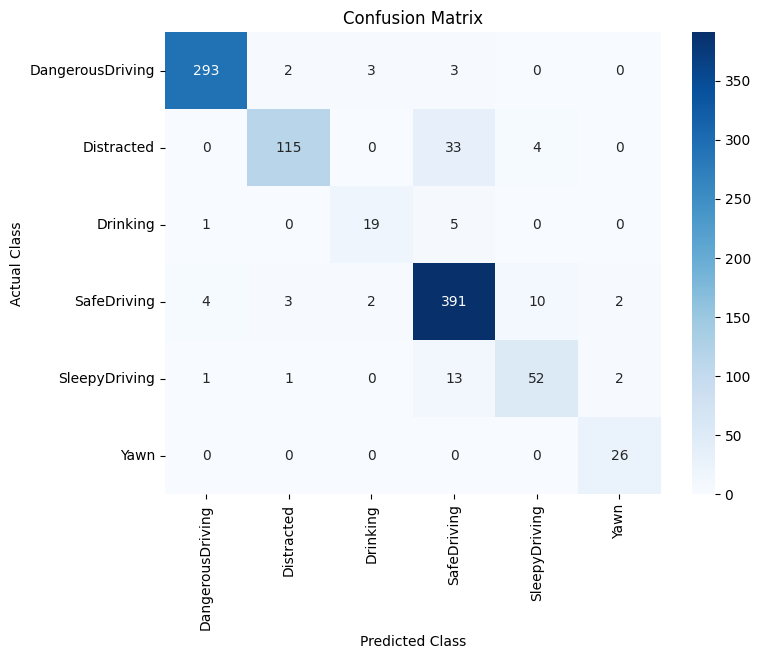

In [ ]:
# Plot confusion matrix for test set
y_pred = improved_model_v3.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Performance measures for test set
report = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print(report)

                  precision    recall  f1-score   support

DangerousDriving       0.98      0.97      0.98       301
      Distracted       0.95      0.76      0.84       152
        Drinking       0.79      0.76      0.78        25
     SafeDriving       0.88      0.95      0.91       412
   SleepyDriving       0.79      0.75      0.77        69
            Yawn       0.87      1.00      0.93        26

        accuracy                           0.91       985
       macro avg       0.88      0.87      0.87       985
    weighted avg       0.91      0.91      0.91       985



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step


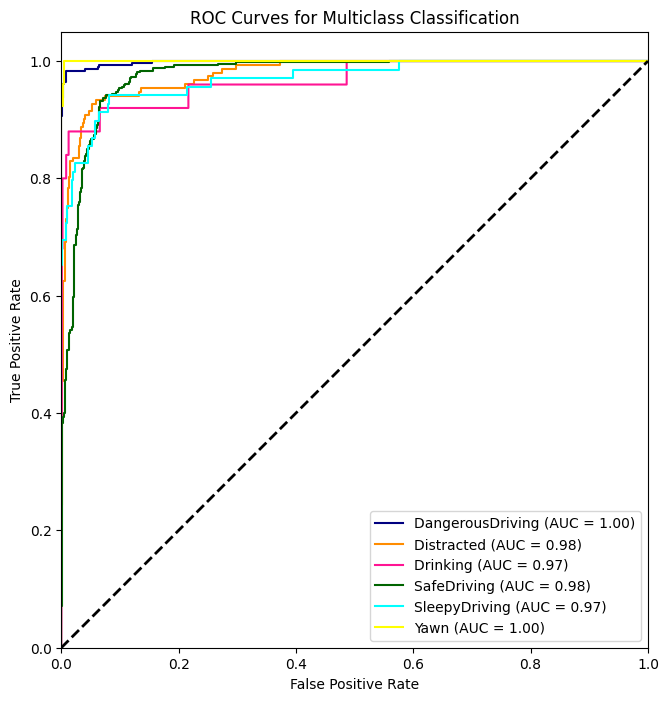

In [ ]:
# Plot ROC curve for test set
y_pred_test = improved_model_v3.predict(test_data)

y_test = test_data.classes
n_classes = len(test_data.class_indices)

y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

Hyperparameter tuning Giada

**second random surch using Uptuna:** I tried more trials and tuned the possible hyperparameters in such a way that they where more aligned with the best parameters Lisa found earlier in the document. The program terminated because it took the long but from the results I did get, the val_accuracy after 6 epochs was 0.8845. Which was promosing. It had the following parameters:  {'num_filters': 64, 'kernel_size': (5, 5), 'dense_units': 30, 'learning_rate': 0.00031908351864226104, 'optimizer_choice': 'Adam', 'activation_function': 'relu', 'n_conv_layers': 4, 'batch_size': 64, 'dropout_rate': 0.21941609636956422}


In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.activations import relu, tanh, sigmoid

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


def create_model(trial):
    num_filters = trial.suggest_categorical('num_filters', [16, 24, 32, 48, 64])
    kernel_size = trial.suggest_categorical('kernel_size', [(3,3), (5,5)])
    dense_units = trial.suggest_int('dense_units', 10, 40, step=10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0003, 0.003)
    optimizer_choice = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    activation_function = trial.suggest_categorical('activation', ['relu', 'elu'])
    n_conv_layers = trial.suggest_int('n_conv_layers', 3, 6, step=1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)

    print("Generated paramaters:", {
        "num_filters": num_filters,
        "kernel_size": kernel_size,
        "dense_units": dense_units,
        "learning_rate": learning_rate,
        "optimizer_choice": optimizer_choice,
        "activation_function": activation_function,
        "n_conv_layers": n_conv_layers,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate,
    })

    conv_layers = [[
        Conv2D(num_filters, kernel_size, activation='relu', input_shape=(img_height, img_width, 1)),
        BatchNormalization(),
        Dropout(dropout_rate),
    ]] + [
        [
          Conv2D(num_filters, kernel_size, activation='relu', input_shape=(img_height, img_width, 1)),
          BatchNormalization(),
          Dropout(dropout_rate),
        ]
        for _index in range(1, n_conv_layers)
    ]

    first_maxpool = n_conv_layers // 3
    second_maxpool = (2 * n_conv_layers) // 3

    conv_layers[first_maxpool].insert(2, MaxPooling2D((2,2)))
    conv_layers[second_maxpool].insert(2, MaxPooling2D((2,2)))

    layers = [layer for section in conv_layers + [[
        Flatten(),
        Dense(dense_units, activation=activation_function),
        Dense(6, activation='softmax')
    ]] for layer in section]


    model = Sequential(layers)

    # Choose optimizers based on the trial
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer choice")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model, {
        'batch_size': batch_size,
    }

def objective(trial):
    model, other_params = create_model(trial)

    history = model.fit(train_data, epochs=6, batch_size=other_params['batch_size'],
                        validation_data=val_data)
    return history.history['val_accuracy'][-1]

# Using Optuna to optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_trial.params)

[I 2025-02-25 09:49:51,661] A new study created in memory with name: no-name-4da72345-e876-4473-887c-651469024778
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
<ipython-input-7-deb7d9cfc4a6>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0003, 0.003)
<ipython-input-7-deb7d9cfc4a6>:14: FutureW

Generated paramaters: {'num_filters': 64, 'kernel_size': (5, 5), 'dense_units': 30, 'learning_rate': 0.0004301435752093676, 'optimizer_choice': 'RMSprop', 'activation_function': 'elu', 'n_conv_layers': 4, 'batch_size': 16, 'dropout_rate': 0.3053909284093926}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2450s 7s/step - accuracy: 0.5552 - loss: 1.2598 - val_accuracy: 0.3309 - val_loss: 3.7934
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2382s 6s/step - accuracy: 0.7718 - loss: 0.6258 - val_accuracy: 0.8293 - val_loss: 0.5861
Epoch 3/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2371s 6s/step - accuracy: 0.8281 - loss: 0.4863 - val_accuracy: 0.8465 - val_loss: 0.4618
Epoch 4/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2233s 6s/step - accuracy: 0.8694 - loss: 0.4016 - val_accuracy: 0.8424 - val_loss: 0.4597
Epoch 5/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2171s 6s/step - accuracy: 0.8798 - loss: 0.3624 - val_accuracy: 0.8444 - val_loss: 0.4772
Epoch 6/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2147s 6s/step - accuracy: 0.8978 - loss: 0.3035 - val_accuracy: 0.8845 - val_loss: 0.4204


[I 2025-02-25 13:39:06,969] Trial 0 finished with value: 0.8844953179359436 and parameters: {'num_filters': 64, 'kernel_size': (5, 5), 'dense_units': 30, 'learning_rate': 0.0004301435752093676, 'optimizer': 'RMSprop', 'activation': 'elu', 'n_conv_layers': 4, 'batch_size': 16, 'dropout_rate': 0.3053909284093926}. Best is trial 0 with value: 0.8844953179359436.


Generated paramaters: {'num_filters': 32, 'kernel_size': (3, 3), 'dense_units': 40, 'learning_rate': 0.0006613383425345519, 'optimizer_choice': 'Adam', 'activation_function': 'elu', 'n_conv_layers': 6, 'batch_size': 128, 'dropout_rate': 0.2386166815726451}
Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.5253 - loss: 1.3590 - val_accuracy: 0.3169 - val_loss: 5.2730
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.7671 - loss: 0.6404 - val_accuracy: 0.7706 - val_loss: 0.6786
Epoch 3/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - accuracy: 0.8215 - loss: 0.4944 - val_accuracy: 0.8340 - val_loss: 0.5260
Epoch 4/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.8480 - loss: 0.4380 - val_accuracy: 0.8460 - val_loss: 0.4765
Epoch 5/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 906s 2s/step - accuracy: 0.8716 - loss: 0.3599 - val_accuracy: 0.8455 - val_loss: 0.4707
Epoch 6/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 899s 2s/step - accuracy: 0.8770 - loss: 0.3417 - val_accuracy: 0

[I 2025-02-25 15:04:26,610] Trial 1 finished with value: 0.8720083236694336 and parameters: {'num_filters': 32, 'kernel_size': (3, 3), 'dense_units': 40, 'learning_rate': 0.0006613383425345519, 'optimizer': 'Adam', 'activation': 'elu', 'n_conv_layers': 6, 'batch_size': 128, 'dropout_rate': 0.2386166815726451}. Best is trial 0 with value: 0.8844953179359436.


Generated paramaters: {'num_filters': 32, 'kernel_size': (5, 5), 'dense_units': 20, 'learning_rate': 0.00031585723664783014, 'optimizer_choice': 'RMSprop', 'activation_function': 'elu', 'n_conv_layers': 6, 'batch_size': 16, 'dropout_rate': 0.39419552883732506}
Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1377s 4s/step - accuracy: 0.3942 - loss: 1.7037 - val_accuracy: 0.3169 - val_loss: 6.0975
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1367s 4s/step - accuracy: 0.6239 - loss: 0.9693 - val_accuracy: 0.6852 - val_loss: 1.0627
Epoch 3/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1292s 3s/step - accuracy: 0.7364 - loss: 0.7188 - val_accuracy: 0.7227 - val_loss: 0.8929
Epoch 4/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1324s 4s/step - accuracy: 0.7784 - loss: 0.6364 - val_accuracy: 0.6405 - val_loss: 1.3604
Epoch 5/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1279s 3s/step - accuracy: 0.8062 - loss: 0.5588 - val_accuracy: 0.8460 - val_loss: 0.5353
Epoch 6/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1283s 3s/step - accuracy: 0.8309 - loss: 0.4798 - val_a

[I 2025-02-25 17:16:28,636] Trial 2 finished with value: 0.8142560124397278 and parameters: {'num_filters': 32, 'kernel_size': (5, 5), 'dense_units': 20, 'learning_rate': 0.00031585723664783014, 'optimizer': 'RMSprop', 'activation': 'elu', 'n_conv_layers': 6, 'batch_size': 16, 'dropout_rate': 0.39419552883732506}. Best is trial 0 with value: 0.8844953179359436.


Generated paramaters: {'num_filters': 64, 'kernel_size': (3, 3), 'dense_units': 10, 'learning_rate': 0.0029105451867931717, 'optimizer_choice': 'Adam', 'activation_function': 'elu', 'n_conv_layers': 3, 'batch_size': 16, 'dropout_rate': 0.41657652938335676}
Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1237s 3s/step - accuracy: 0.4075 - loss: 2.1022 - val_accuracy: 0.4157 - val_loss: 1.4113
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1231s 3s/step - accuracy: 0.4122 - loss: 1.4197 - val_accuracy: 0.4058 - val_loss: 1.6341
Epoch 3/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1241s 3s/step - accuracy: 0.4088 - loss: 1.4104 - val_accuracy: 0.4084 - val_loss: 1.5350
Epoch 4/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1291s 3s/step - accuracy: 0.4189 - loss: 1.4016 - val_accuracy: 0.4100 - val_loss: 1.5356
Epoch 5/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1282s 3s/step - accuracy: 0.4191 - loss: 1.4150 - val_accuracy: 0.4089 - val_loss: 1.5460
Epoch 6/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 1327s 4s/step - accuracy: 0.4106 - loss: 1.4135 - val_accur

[I 2025-02-25 19:23:18,307] Trial 3 finished with value: 0.4068678319454193 and parameters: {'num_filters': 64, 'kernel_size': (3, 3), 'dense_units': 10, 'learning_rate': 0.0029105451867931717, 'optimizer': 'Adam', 'activation': 'elu', 'n_conv_layers': 3, 'batch_size': 16, 'dropout_rate': 0.41657652938335676}. Best is trial 0 with value: 0.8844953179359436.


Generated paramaters: {'num_filters': 24, 'kernel_size': (5, 5), 'dense_units': 40, 'learning_rate': 0.0005412565961822024, 'optimizer_choice': 'RMSprop', 'activation_function': 'relu', 'n_conv_layers': 4, 'batch_size': 32, 'dropout_rate': 0.46584601981718354}
Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.4528 - loss: 1.4766 - val_accuracy: 0.3163 - val_loss: 4.5404
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.7254 - loss: 0.7647 - val_accuracy: 0.7071 - val_loss: 0.8652
Epoch 3/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.7845 - loss: 0.6273 - val_accuracy: 0.7539 - val_loss: 0.7134
Epoch 4/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.8113 - loss: 0.5584 - val_accuracy: 0.7914 - val_loss: 0.7591
Epoch 5/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.8331 - loss: 0.4746 - val_accuracy: 0.8002 - val_loss: 0.6466
Epoch 6/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.8441 - loss: 0.4416 - val_accurac

[I 2025-02-25 20:21:07,231] Trial 4 finished with value: 0.8418314456939697 and parameters: {'num_filters': 24, 'kernel_size': (5, 5), 'dense_units': 40, 'learning_rate': 0.0005412565961822024, 'optimizer': 'RMSprop', 'activation': 'relu', 'n_conv_layers': 4, 'batch_size': 32, 'dropout_rate': 0.46584601981718354}. Best is trial 0 with value: 0.8844953179359436.


Generated paramaters: {'num_filters': 48, 'kernel_size': (5, 5), 'dense_units': 10, 'learning_rate': 0.0023114809957191338, 'optimizer_choice': 'RMSprop', 'activation_function': 'relu', 'n_conv_layers': 6, 'batch_size': 16, 'dropout_rate': 0.28173655834772804}
Epoch 1/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2299s 6s/step - accuracy: 0.4134 - loss: 1.7866 - val_accuracy: 0.3866 - val_loss: 3.2638
Epoch 2/6
374/374 ━━━━━━━━━━━━━━━━━━━━ 2302s 6s/step - accuracy: 0.5135 - loss: 1.3056 - val_accuracy: 0.5109 - val_loss: 1.4619
Epoch 3/6
 95/374 ━━━━━━━━━━━━━━━━━━━━ 28:37 6s/step - accuracy: 0.6105 - loss: 1.1307

Tried running the model with these parameters with 30 epochs(aka: {'num_filters': 64, 'kernel_size': (5, 5), 'dense_units': 30, 'learning_rate': 0.00031908351864226104, 'optimizer_choice': 'Adam', 'activation_function': 'relu', 'n_conv_layers': 4, 'batch_size': 64, 'dropout_rate': 0.21941609636956422}). It got a val_accuracy of val_accuracy: 0.9350.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 68, 124, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 68, 124, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 34, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 34, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 58, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 54, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 9, 23, 64)           │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 23, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13248)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13248)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │         397,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             186 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 707,736 (2.70 MB)

 Trainable params: 707,224 (2.70 MB)

 Non-trainable params: 512 (2.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1047s 3s/step - accuracy: 0.5564 - loss: 1.2116 - val_accuracy: 0.5359 - val_loss: 1.7328
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1074s 3s/step - accuracy: 0.7689 - loss: 0.6266 - val_accuracy: 0.8221 - val_loss: 0.5321
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1018s 3s/step - accuracy: 0.8299 - loss: 0.4782 - val_accuracy: 0.8632 - val_loss: 0.4204
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1019s 3s/step - accuracy: 0.8678 - loss: 0.3844 - val_accuracy: 0.8476 - val_loss: 0.5091
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1015s 3s/step - accuracy: 0.8885 - loss: 0.3292 - val_accuracy: 0.8887 - val_loss: 0.3504
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1017s 3s/step - accuracy: 0.9019 - loss: 0.2786 - val_accuracy: 0.9048 - val_loss: 0.3220
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1018s 3s/step - accuracy: 0.9092 - loss: 0.2629 - val_accuracy: 0.8949 - val_loss: 0.3409
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 1019s 3s/step - accuracy: 0.9147 - loss: 0.2525 - 

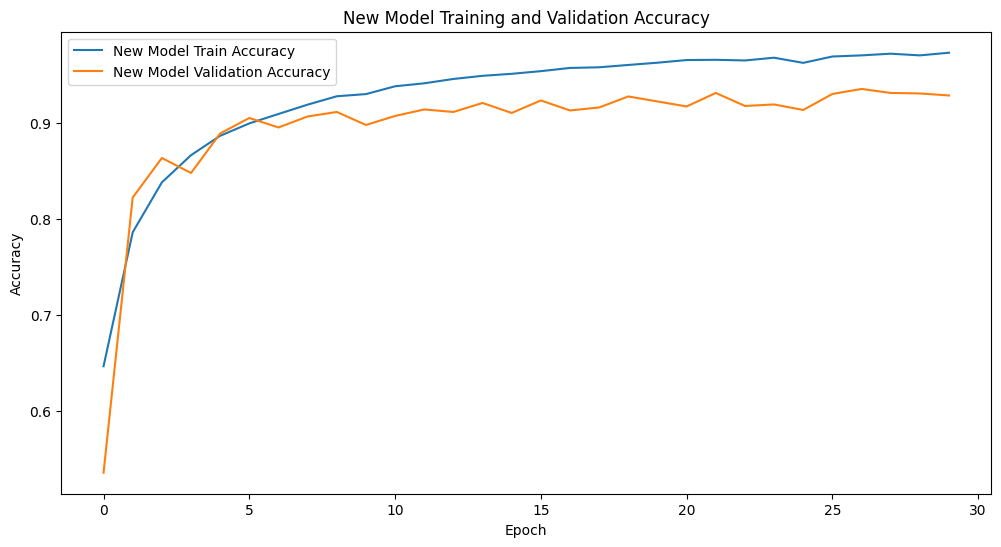

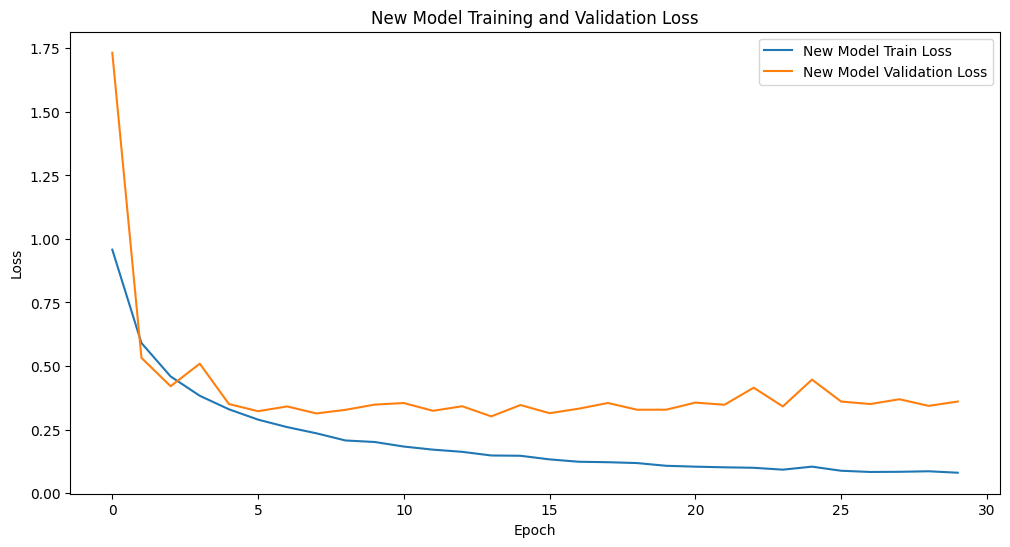

NameError: name 'y_true_val' is not defined

In [ ]:
#Generated paramaters: {'num_filters': 64, 'kernel_size': (5, 5), 'dense_units': 30, 'learning_rate': 0.00031908351864226104, 'optimizer_choice': 'Adam', 'activation_function': 'relu', 'n_conv_layers': 4, 'batch_size': 64, 'dropout_rate': 0.21941609636956422}
# GETRAIND
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Define the new model
new_model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.21941609636956422),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    Dropout(0.21941609636956422),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.21941609636956422),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.21941609636956422),
    Dense(30, activation='relu'),
    Dense(6, activation='softmax')
])

# Print the summary of the new model
new_model.summary()

# Compile the new model
optimizer = Adam(learning_rate=0.00031908351864226104)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the new model
new_history = new_model.fit(train_data, epochs=30, batch_size=64, validation_data=val_data)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['accuracy'], label='New Model Train Accuracy')
plt.plot(new_history.history['val_accuracy'], label='New Model Validation Accuracy')
plt.title('New Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['loss'], label='New Model Train Loss')
plt.plot(new_history.history['val_loss'], label='New Model Validation Loss')
plt.title('New Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Performance measures for validation set
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys())
print("Validation Set Classification Report:")
print(report_val)

# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Test Set Classification Report:")
print(report_test)

Then, I tried adding L2 regularization to the model, but that didnt work, the accuracy decreased. Even at low dropout and L2 values.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 68, 124, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 68, 124, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 34, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 58, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 30, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 26, 54, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 26, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 13, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 9, 23, 64)           │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 9, 23, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 13248)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 13248)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │         397,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             186 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 707,736 (2.70 MB)

 Trainable params: 707,224 (2.70 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.5804 - loss: 1.3838 - val_accuracy: 0.5219 - val_loss: 1.9021
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.7912 - loss: 0.8355 - val_accuracy: 0.8392 - val_loss: 0.8124
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.8542 - loss: 0.6665 - val_accuracy: 0.8689 - val_loss: 0.6695
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.8810 - loss: 0.5861 - val_accuracy: 0.8855 - val_loss: 0.5956
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - accuracy: 0.8940 - loss: 0.5304 - val_accuracy: 0.8933 - val_loss: 0.5926
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9099 - loss: 0.4815 - val_accuracy: 0.8647 - val_loss: 0.6398
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.9242 - loss: 0.4462 - val_accuracy: 0.8980 - val_loss: 0.5530
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.9358 - loss: 0.4072 - val_accu

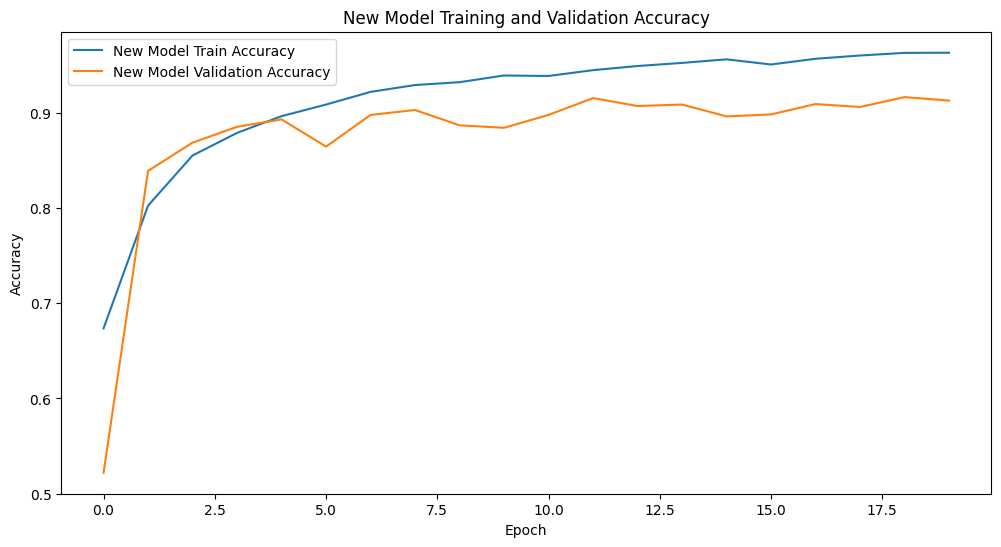

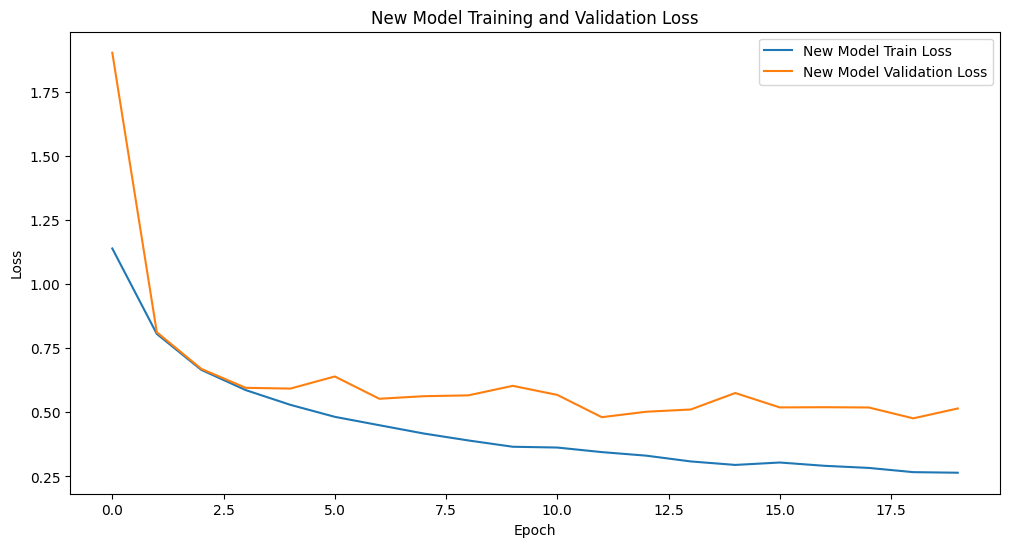

In [ ]:
from tensorflow.keras import regularizers


# Define the new model with L2 regularization
new_model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(img_height, img_width, 1),
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (5, 5), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Conv2D(64, (5, 5), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
     Conv2D(64, (5, 5), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.1),
    Dense(30, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(6, activation='softmax')
])

# Print the model summary to verify the architecture
new_model.summary()

# Compile the new model
optimizer = Adam(learning_rate=0.00031908351864226104)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the new model
new_history = new_model.fit(train_data, epochs=20, batch_size=64, validation_data=val_data)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['accuracy'], label='New Model Train Accuracy')
plt.plot(new_history.history['val_accuracy'], label='New Model Validation Accuracy')
plt.title('New Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['loss'], label='New Model Train Loss')
plt.plot(new_history.history['val_loss'], label='New Model Validation Loss')
plt.title('New Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Instead, to reduce overfitting I increased the dropout to 0.25 and removed L2 regularization. I also made the model bigger and changed it architecture. The first layers starts at 32 filters, and each layers this number gets doubled. I choose this architecture because the width and height of the latent space decreases with depth because of the maxpooling layers. To maintain the same amount of information, I decided to increase the number of channels at every layer. This model gave the best accuracy (next cell)

# Model with best accuracy score(final model)

Best model from hyperparameters tuninig(Giada). At epoch 34 out of 35 google collab stopped the execution (probably because of rate limit). I then loaded the best model up to epoch 33 and generated the graphs and reports based on that model in the second cell below. Below that, I put a few experiments that I did to get to this score

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/content/gdrive')
import datetime
now = str(datetime.datetime.now())

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


# Define the new model
new_model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(128, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (5, 5), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.25),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Print the model summary to verify the architecture
new_model.summary()


# Compile the new model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00031908351864226104)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define the ModelCheckpoint callback
checkpoint_filepath = f'/content/gdrive/MyDrive/dss_deep_learning/best_model {now}.weights.h5'
print(f"{checkpoint_filepath=}")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only = True,
    verbose=1
)

# Train the new model with the ModelCheckpoint callback
new_history = new_model.fit(train_data, epochs=35, batch_size=64, validation_data=val_data,
                            callbacks=[model_checkpoint_callback])


# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['accuracy'], label='New Model Train Accuracy')
plt.plot(new_history.history['val_accuracy'], label='New Model Validation Accuracy')
plt.title('New Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(new_history.history['loss'], label='New Model Train Loss')
plt.plot(new_history.history['val_loss'], label='New Model Validation Loss')
plt.title('New Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best weights
new_model.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
y_pred_test = new_model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

# Plot ROC curve for validation set
y_pred_val = new_model.predict(val_data)
y_val = val_data.classes
n_classes = len(val_data.class_indices)
y_onehot_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
class_labels = list(val_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Validation set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
y_pred_test = new_model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test set')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix for validation set
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val  = val_data.classes
cm = confusion_matrix(y_true_val, y_pred_classes_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title('Confusion Matrix of Validation set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot confusion matrix for test set
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Performance measures for validation set
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys()))
print("Validation Set Classification Report:")
print(report_val)

# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Test Set Classification Report:")
print(report_test)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 11948 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)                   │ (None, 68, 124, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 68, 124, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 34, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 34, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 30, 58, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 30, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 30, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 26, 54, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 26, 54, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 13, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 13, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 9, 23, 256)          │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 9, 23, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 52992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 52992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 60)                  │       3,179,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 6)                   │             186 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,259,996 (16.25 MB)

 Trainable params: 4,259,036 (16.25 MB)

 Non-trainable params: 960 (3.75 KB)

checkpoint_filepath='/content/gdrive/MyDrive/dss_deep_learning/best_model 2025-02-28 22:56:07.260075.weights.h5'
Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4713 - loss: 1.3587
Epoch 1: val_accuracy improved from -inf to 0.37825, saving model to /content/gdrive/MyDrive/dss_deep_learning/best_model 2025-02-28 22:56:07.260075.weights.h5
374/374 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - accuracy: 0.4715 - loss: 1.3582 - val_accuracy: 0.3783 - val_loss: 10.6653
Epoch 2/35
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7083 - loss: 0.8298
Epoch 2: val_accuracy improved from 0.37825 to 0.75806, saving model to /content/gdrive/MyDrive/dss_deep_learning/best_model 2025-02-28 22:56:07.260075.weights.h5
374/374 ━━━━━━━━━━━━━━━━━━━━ 1089s 3s/step - accuracy: 0.7083 - loss: 0.8297 - val_accuracy: 0.7581 - val_loss: 1.1145
Epoch 3/35
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7921 - loss: 0.6184
Epoch 3: val_accuracy did not improve from 0.75806
374/374 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - accuracy: 0.7921 - loss: 0.6183 - val_accuracy: 0.5598 - val_loss: 5.9306
Epoch 4/35
374/374 ━━━━━

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 11948 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 68, 124, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 68, 124, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 34, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 58, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 30, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 26, 54, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 26, 54, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 13, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 9, 23, 256)          │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 9, 23, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 52992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 52992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 60)                  │       3,179,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             186 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,259,996 (16.25 MB)

 Trainable params: 4,259,036 (16.25 MB)

 Non-trainable params: 960 (3.75 KB)

checkpoint_filepath='/content/gdrive/MyDrive/dss_deep_learning/best_model 2025-02-28 22:56:07.260075.weights.h5'


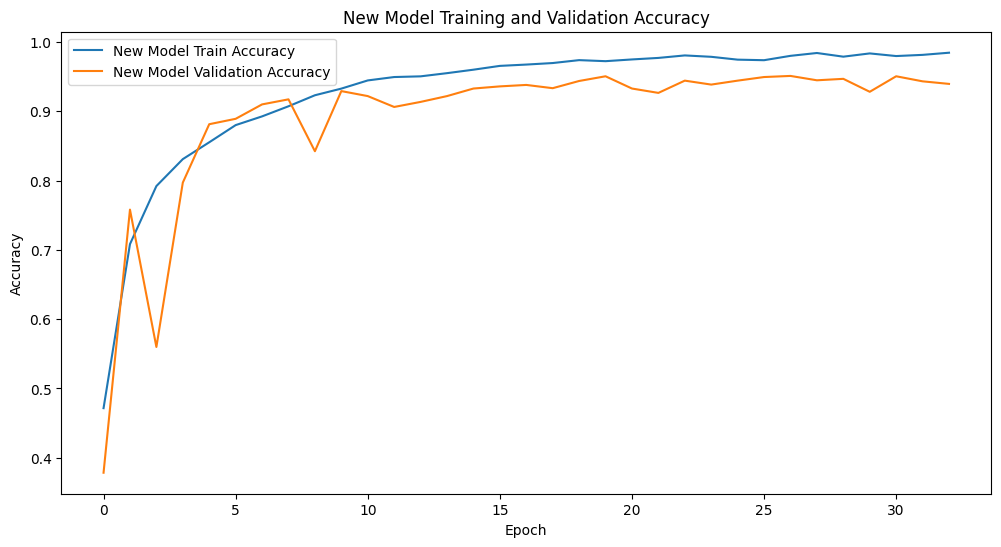

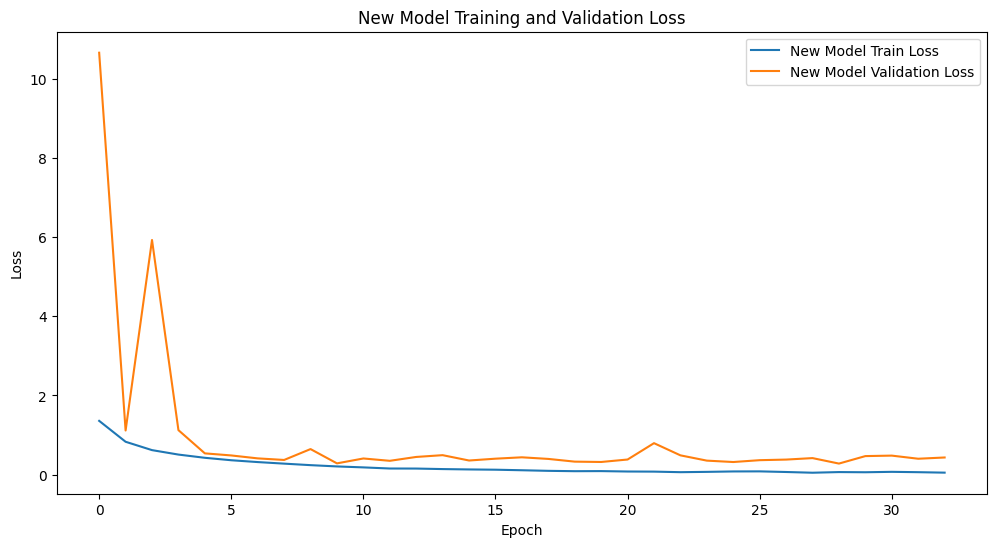

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 531ms/step


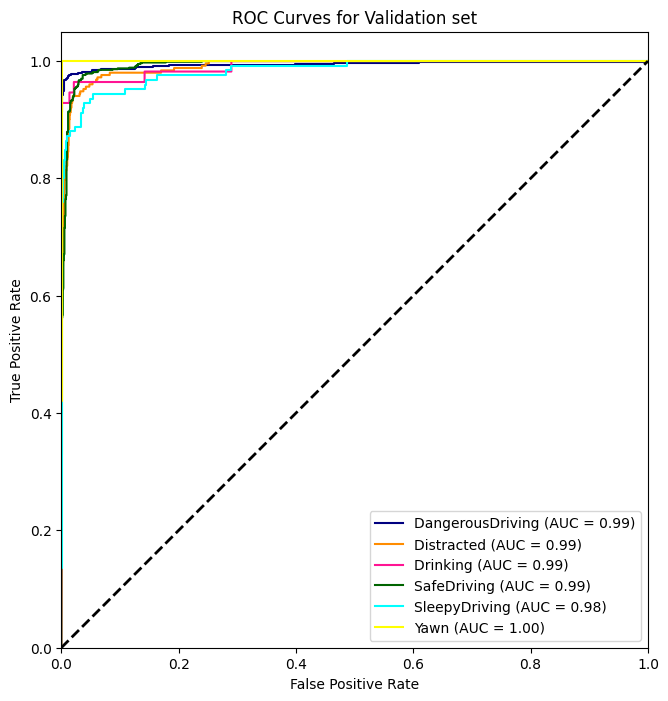

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step


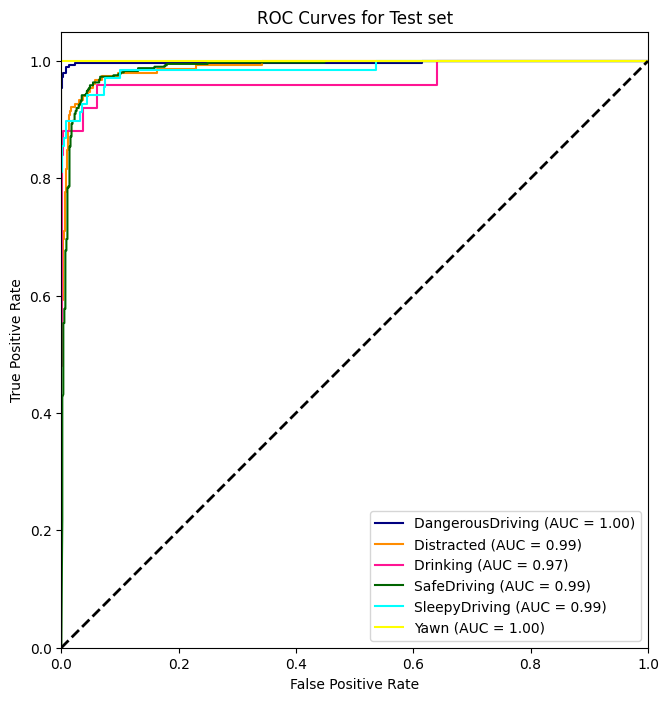

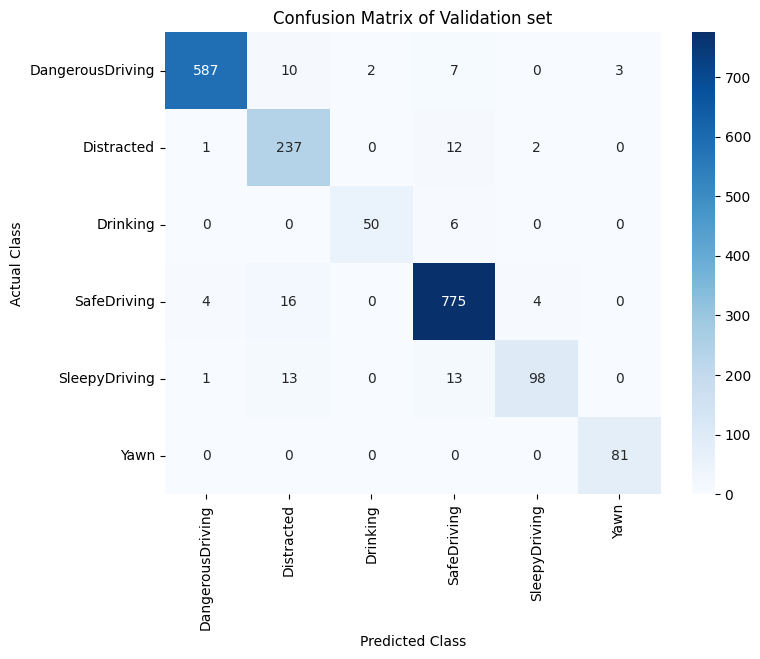

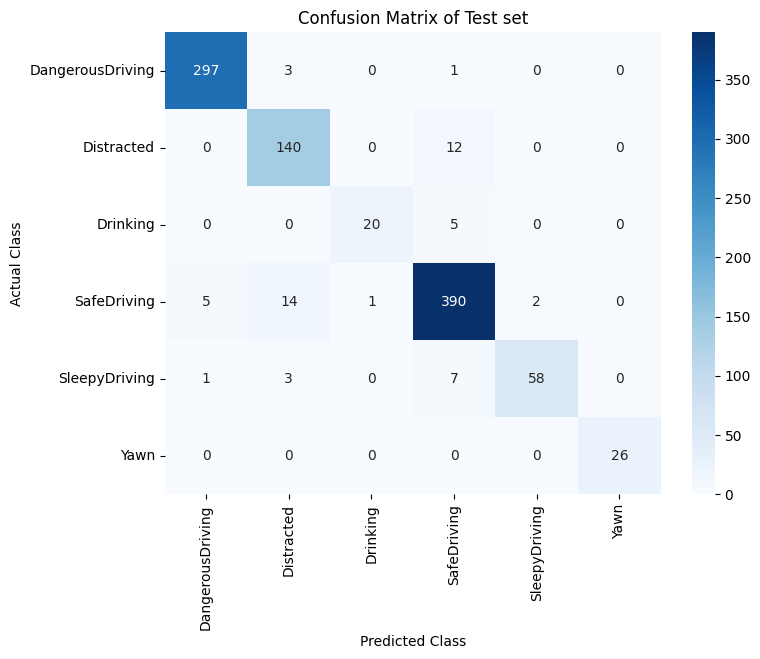

Validation Set Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.99      0.96      0.98       609
      Distracted       0.86      0.94      0.90       252
        Drinking       0.96      0.89      0.93        56
     SafeDriving       0.95      0.97      0.96       799
   SleepyDriving       0.94      0.78      0.86       125
            Yawn       0.96      1.00      0.98        81

        accuracy                           0.95      1922
       macro avg       0.94      0.93      0.93      1922
    weighted avg       0.95      0.95      0.95      1922

Test Set Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.98      0.99      0.98       301
      Distracted       0.88      0.92      0.90       152
        Drinking       0.95      0.80      0.87        25
     SafeDriving       0.94      0.95      0.94       412
   SleepyDriving       0.97      0.84      0.90        6

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/content/gdrive')

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


# Define the new model
new_model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(128, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (5, 5), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.25),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Print the model summary to verify the architecture
new_model.summary()


# Compile the new model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00031908351864226104)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

start_training_time_of_loaded_model = '2025-02-28 22:56:07.260075'

# Define the ModelCheckpoint callback
checkpoint_filepath = f'/content/gdrive/MyDrive/dss_deep_learning/best_model {start_training_time_of_loaded_model}.weights.h5'
print(f"{checkpoint_filepath=}")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only = True,
    verbose=1
)

# Values extracted from the logs:
train_accuracy = [
    0.4715, 0.7083, 0.7921, 0.8310, 0.8553, 0.8801, 0.8927, 0.9073, 0.9232, 0.9328,
    0.9446, 0.9495, 0.9505, 0.9551, 0.9601, 0.9656, 0.9675, 0.9697, 0.9739, 0.9724,
    0.9749, 0.9771, 0.9807, 0.9787, 0.9746, 0.9738, 0.9801, 0.9842, 0.9789, 0.9836,
    0.9798, 0.9815, 0.9846
]

val_accuracy = [
    0.3783, 0.7581, 0.5598, 0.7971, 0.8814, 0.8892, 0.9100, 0.9173, 0.8424, 0.9292,
    0.9220, 0.9063, 0.9136, 0.9220, 0.9329, 0.9360, 0.9381, 0.9334, 0.9438, 0.9506,
    0.9329, 0.9266, 0.9443, 0.9386, 0.9443, 0.9495, 0.9511, 0.9448, 0.9469, 0.9282,
    0.9506, 0.9433, 0.9396
]

train_loss = [
    1.3582, 0.8297, 0.6183, 0.5057, 0.4243, 0.3623, 0.3162, 0.2766, 0.2384, 0.2060,
    0.1817, 0.1534, 0.1522, 0.1391, 0.1299, 0.1233, 0.1095, 0.0946, 0.0858, 0.0879,
    0.0776, 0.0748, 0.0607, 0.0686, 0.0793, 0.0812, 0.0652, 0.0470, 0.0633, 0.0589,
    0.0694, 0.0606, 0.0489
]

val_loss = [
    10.6653, 1.1145, 5.9306, 1.1235, 0.5362, 0.4837, 0.4096, 0.3698, 0.6447, 0.2835,
    0.4071, 0.3481, 0.4458, 0.4908, 0.3557, 0.4020, 0.4367, 0.3959, 0.3272, 0.3186,
    0.3808, 0.7943, 0.4862, 0.3527, 0.3176, 0.3641, 0.3792, 0.4166, 0.2782, 0.4674,
    0.4795, 0.4006, 0.4321
]


# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='New Model Train Accuracy')
plt.plot(val_accuracy, label='New Model Validation Accuracy')
plt.title('New Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='New Model Train Loss')
plt.plot(val_loss, label='New Model Validation Loss')
plt.title('New Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best weights
new_model.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
y_pred_test = new_model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

# Plot ROC curve for validation set
y_pred_val = new_model.predict(val_data)
y_val = val_data.classes
n_classes = len(val_data.class_indices)
y_onehot_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
class_labels = list(val_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Validation set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
y_pred_test = new_model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test set')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix for validation set
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val  = val_data.classes
cm = confusion_matrix(y_true_val, y_pred_classes_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title('Confusion Matrix of Validation set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot confusion matrix for test set
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Performance measures for validation set
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys()))
print("Validation Set Classification Report:")
print(report_val)

# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Test Set Classification Report:")
print(report_test)


# Data preprocessing for transfer model

Change colormode to rgb because this is epxected by pretrained basemodels


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# rgb instead of grayscale for transfer model
train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb')

# rgb instead of grayscale for transfer model
val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb')

# rgb instead of grayscale for transfer model
test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb')


# Transfer learning

First we will be using transfer learning on densenet. The hyperparameters will be tuned first

First, I tried a simple model with 2 dense layers and batch normalization to improve the training process and increase the model's generalization capability. val_accuracy: 0.7929 was the highest accuracy (not great)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,302,470 (27.86 MB)

 Trainable params: 264,454 (1.01 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.5181 - loss: 1.4685

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 261s 668ms/step - accuracy: 0.5183 - loss: 1.4675 - val_accuracy: 0.7487 - val_loss: 0.7137
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 258s 656ms/step - accuracy: 0.6942 - loss: 0.8079 - val_accuracy: 0.6795 - val_loss: 0.8495
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 244s 653ms/step - accuracy: 0.7268 - loss: 0.7358 - val_accuracy: 0.7685 - val_loss: 0.6501
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 250s 669ms/step - accuracy: 0.7387 - loss: 0.7020 - val_accuracy: 0.7773 - val_loss: 0.6271
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 246s 658ms/step - accuracy: 0.7616 - loss: 0.6630 - val_accuracy: 0.7794 - val_loss: 0.6358
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 247s 659ms/step - accuracy: 0.7633 - loss: 0.6614 - val_accuracy: 0.7877 - val_loss: 0.6243
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 261s 656ms/step - accuracy: 0.7609 - loss: 0.6569 - val_accuracy: 0.7784 - val_loss: 0.6093
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 247s 661ms/step - accuracy: 0.7616 - loss: 0.65

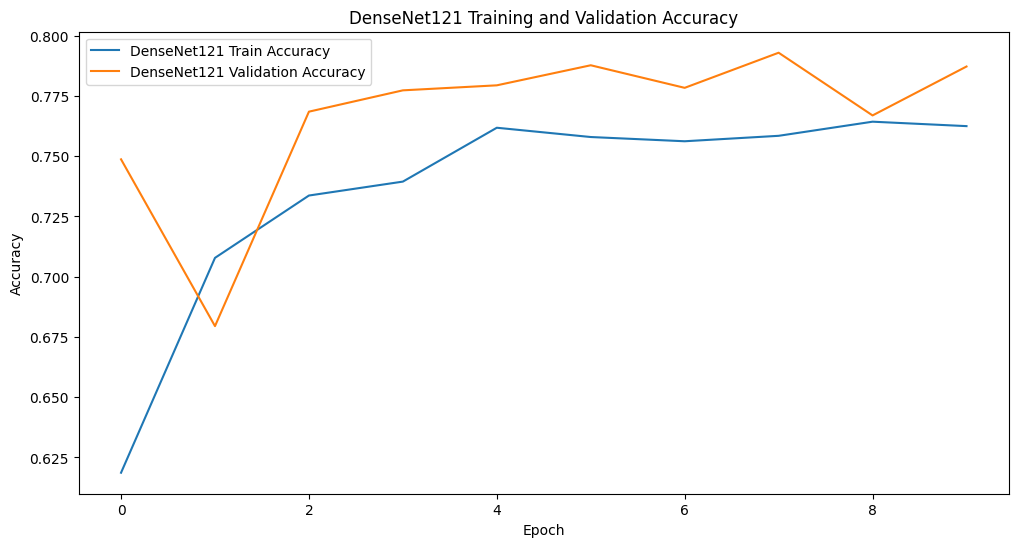

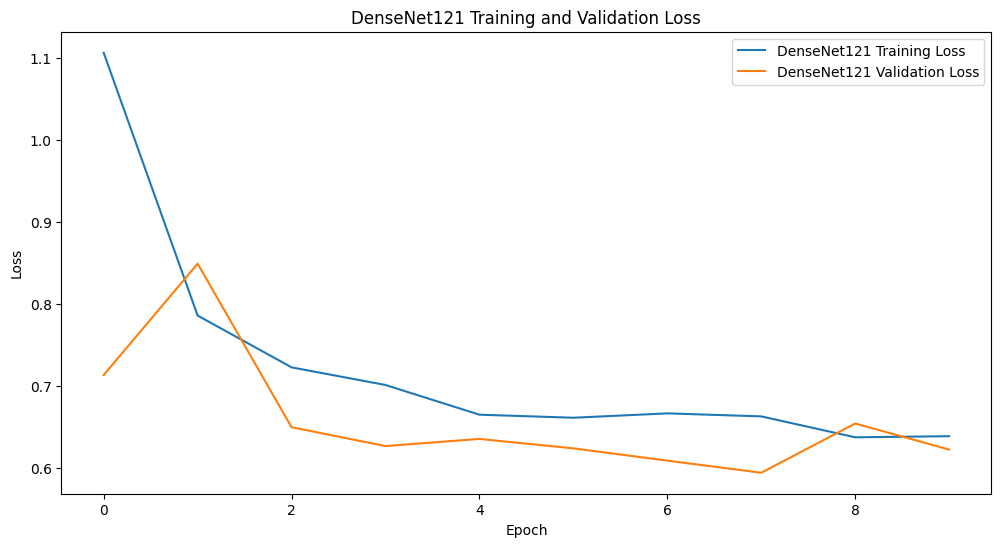

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 655ms/step


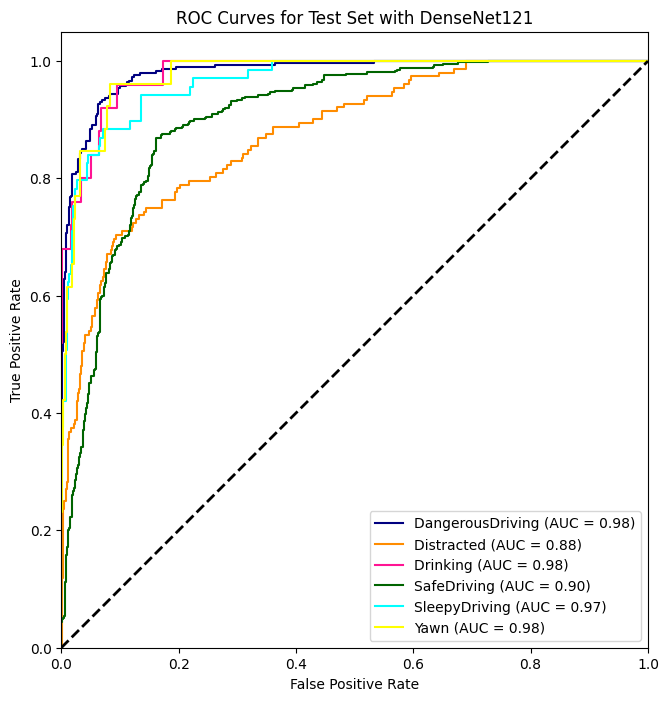

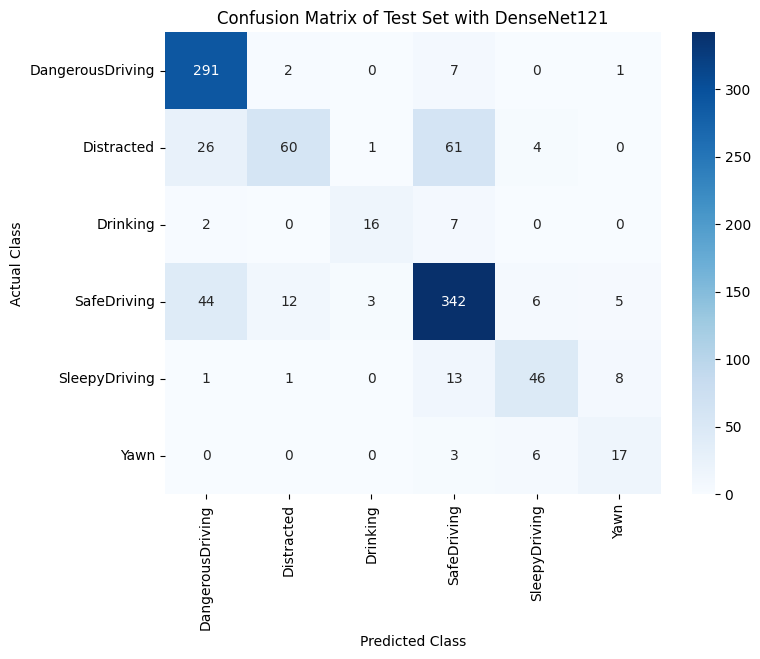

Classification Report of Test Set with DenseNet121:
                  precision    recall  f1-score   support

DangerousDriving       0.80      0.97      0.88       301
      Distracted       0.80      0.39      0.53       152
        Drinking       0.80      0.64      0.71        25
     SafeDriving       0.79      0.83      0.81       412
   SleepyDriving       0.74      0.67      0.70        69
            Yawn       0.55      0.65      0.60        26

        accuracy                           0.78       985
       macro avg       0.75      0.69      0.70       985
    weighted avg       0.78      0.78      0.77       985



In [ ]:
from tensorflow.keras.applications import DenseNet121

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)


# Load DenseNet121 pre-trained on imagenet, without the top (fully connected layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom fully connected layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Print model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='DenseNet121 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='DenseNet121 Validation Accuracy')
plt.title('DenseNet121 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='DenseNet121 Training Loss')
plt.plot(history.history['val_loss'], label='DenseNet121 Validation Loss')
plt.title('DenseNet121 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred_test = model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

# Plot ROC curve for the test set
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test Set with DenseNet121')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
y_pred_classes = np.argmax(y_pred_test, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test Set with DenseNet121')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print classification report
report = classification_report(y_test, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Classification Report of Test Set with DenseNet121:")
print(report)

Then, I added one extra dense layers and increased the size of the dense layer. The validation accuracy improved to val_accuracy: 0.8309

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,730,886 (29.49 MB)

 Trainable params: 691,590 (2.64 MB)

 Non-trainable params: 7,039,296 (26.85 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 284s 718ms/step - accuracy: 0.4543 - loss: 1.6241 - val_accuracy: 0.7362 - val_loss: 0.7470
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 264s 705ms/step - accuracy: 0.6785 - loss: 0.8848 - val_accuracy: 0.7664 - val_loss: 0.6643
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 253s 678ms/step - accuracy: 0.7274 - loss: 0.7611 - val_accuracy: 0.7680 - val_loss: 0.6300
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 252s 675ms/step - accuracy: 0.7366 - loss: 0.7147 - val_accuracy: 0.7945 - val_loss: 0.5968
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 253s 676ms/step - accuracy: 0.7420 - loss: 0.6834 - val_accuracy: 0.7924 - val_loss: 0.5880
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 297s 794ms/step - accuracy: 0.7500 - loss: 0.6664 - val_accuracy: 0.8117 - val_loss: 0.5552
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 344s 920ms/step - accuracy: 0.7556 - loss: 0.6528 - val_accuracy: 0.8309 - val_loss: 0.5152
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 299s 800ms/step - accuracy: 0.7664 -

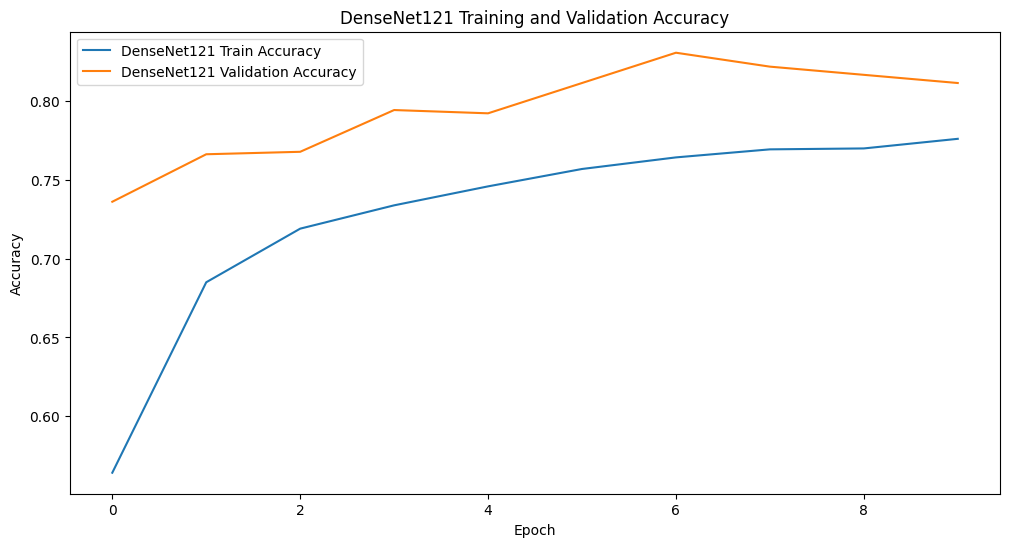

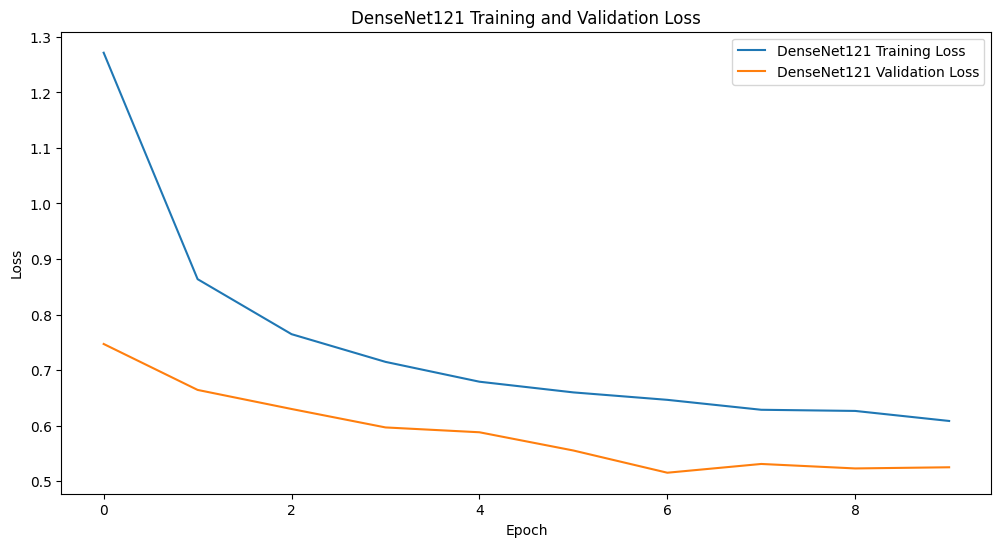

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 792ms/step


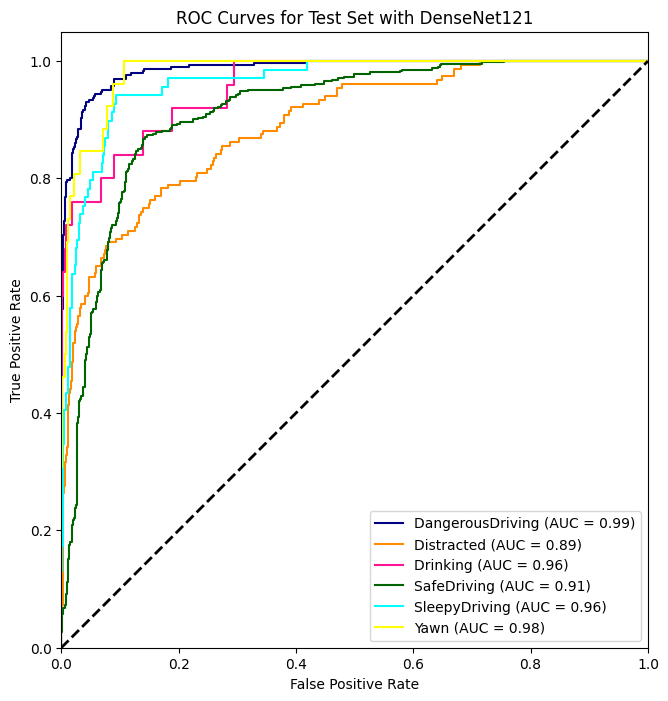

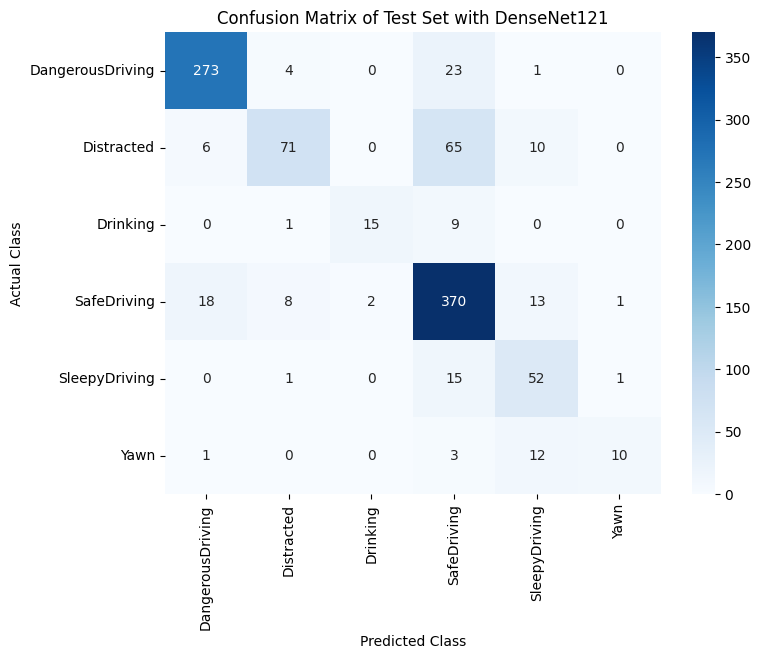

Classification Report of Test Set with DenseNet121:
                  precision    recall  f1-score   support

DangerousDriving       0.92      0.91      0.91       301
      Distracted       0.84      0.47      0.60       152
        Drinking       0.88      0.60      0.71        25
     SafeDriving       0.76      0.90      0.82       412
   SleepyDriving       0.59      0.75      0.66        69
            Yawn       0.83      0.38      0.53        26

        accuracy                           0.80       985
       macro avg       0.80      0.67      0.71       985
    weighted avg       0.81      0.80      0.79       985



In [ ]:
#Densenet, Giada
from tensorflow.keras.applications import DenseNet121

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)


# Load DenseNet121 pre-trained on imagenet, without the top (fully connected layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom fully connected layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'), # Increased the size of dense layers
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'), # Added one dense layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Print model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='DenseNet121 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='DenseNet121 Validation Accuracy')
plt.title('DenseNet121 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='DenseNet121 Training Loss')
plt.plot(history.history['val_loss'], label='DenseNet121 Validation Loss')
plt.title('DenseNet121 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred_test = model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

# Plot ROC curve for the test set
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test Set with DenseNet121')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
y_pred_classes = np.argmax(y_pred_test, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test Set with DenseNet121')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print classification report
report = classification_report(y_test, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Classification Report of Test Set with DenseNet121:")
print(report)

# Best Transfer model
To improve the model I tried a learning rate scheduler because from the previous model I saw that the validation accuracy was jumping around. The learning rate scheduler should decrease the learning rate later on in the training, decreasing the chance of overshooting the optimal parameter values.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.
Found 11948 validated image filenames belonging to 6 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,730,886 (29.49 MB)

 Trainable params: 691,590 (2.64 MB)

 Non-trainable params: 7,039,296 (26.85 MB)

checkpoint_filepath='/content/gdrive/MyDrive/dss_deep_learning/best_model_densenet121_transfer 2025-03-01 12:45:58.898305.weights.h5'


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.4545 - loss: 1.6241
Epoch 1: val_accuracy improved from -inf to 0.72320, saving model to /content/gdrive/MyDrive/dss_deep_learning/best_model_densenet121_transfer 2025-03-01 12:45:58.898305.weights.h5
374/374 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.4548 - loss: 1.6232 - val_accuracy: 0.7232 - val_loss: 0.7629 - learning_rate: 0.0010
Epoch 2/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.6810 - loss: 0.8678
Epoch 2: val_accuracy improved from 0.72320 to 0.76587, saving model to /content/gdrive/MyDrive/dss_deep_learning/best_model_densenet121_transfer 2025-03-01 12:45:58.898305.weights.h5
374/374 ━━━━━━━━━━━━━━━━━━━━ 371s 993ms/step - accuracy: 0.6810 - loss: 0.8678 - val_accuracy: 0.7659 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 3/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.7220 - loss: 0.7680
Epoch 3: val_accuracy improved from 0.76587 to 0.78408, saving model to /content/gdr

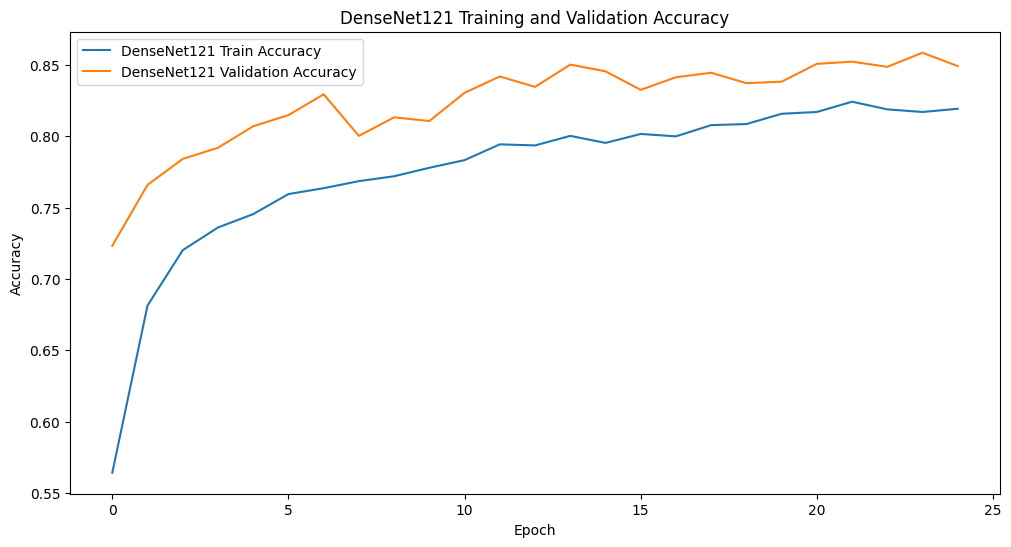

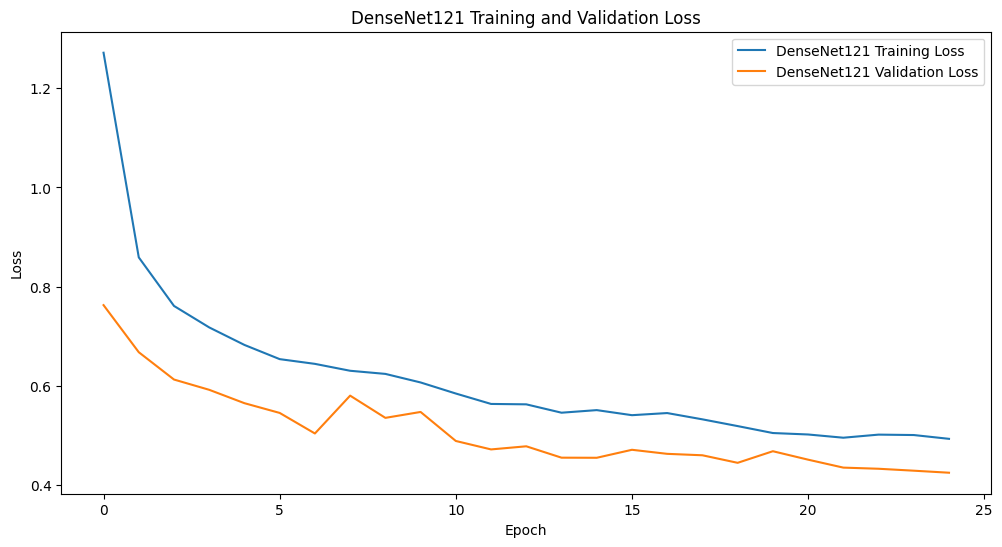

NameError: name 'new_model' is not defined

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount('/content/gdrive')

import datetime
now = str(datetime.datetime.now())

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)

# Load DenseNet121 pre-trained on imagenet, without the top (fully connected layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom fully connected layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Print model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define training callbacks:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

checkpoint_filepath = f'/content/gdrive/MyDrive/dss_deep_learning/best_model_densenet121_transfer {now}.weights.h5'
print(f"{checkpoint_filepath=}")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only = True,
    verbose=1
)

# Train the model
history = model.fit(train_data, epochs=25, batch_size=64, validation_data=val_data, callbacks=[lr_scheduler, model_checkpoint_callback])

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='DenseNet121 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='DenseNet121 Validation Accuracy')
plt.title('DenseNet121 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='DenseNet121 Training Loss')
plt.plot(history.history['val_loss'], label='DenseNet121 Validation Loss')
plt.title('DenseNet121 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best weights
model.load_weights(checkpoint_filepath)

# Plot ROC curve for validation set
y_pred_val = model.predict(val_data)
y_val = val_data.classes
n_classes = len(val_data.class_indices)
y_onehot_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
class_labels = list(val_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Validation set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
y_pred_test = model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test set')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix for validation set
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val  = val_data.classes
cm = confusion_matrix(y_true_val, y_pred_classes_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title('Confusion Matrix of Validation set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot confusion matrix for test set
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Performance measures for validation set
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys()))
print("Validation Set Classification Report:")
print(report_val)

# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Test Set Classification Report:")
print(report_test)

The ROC curves and confusion matrix for the best Densenet model above are in the cell below

61/61 ━━━━━━━━━━━━━━━━━━━━ 59s 891ms/step


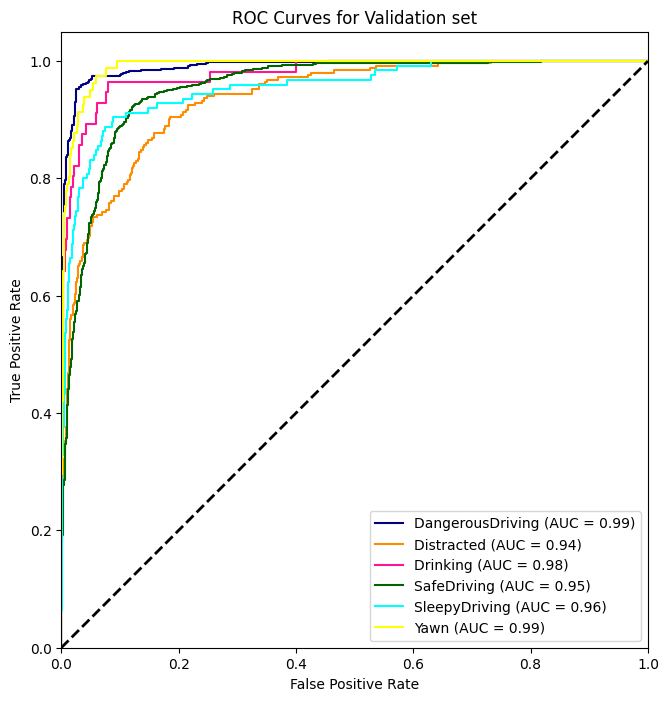

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 844ms/step


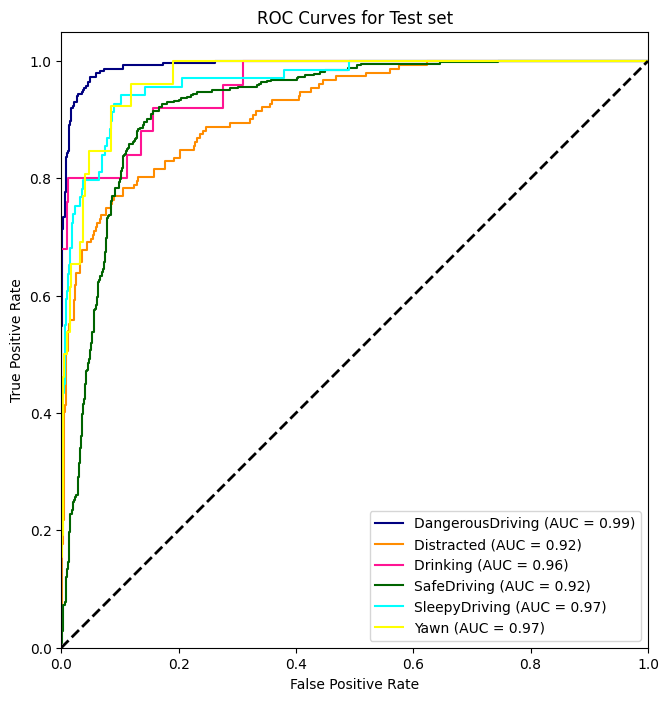

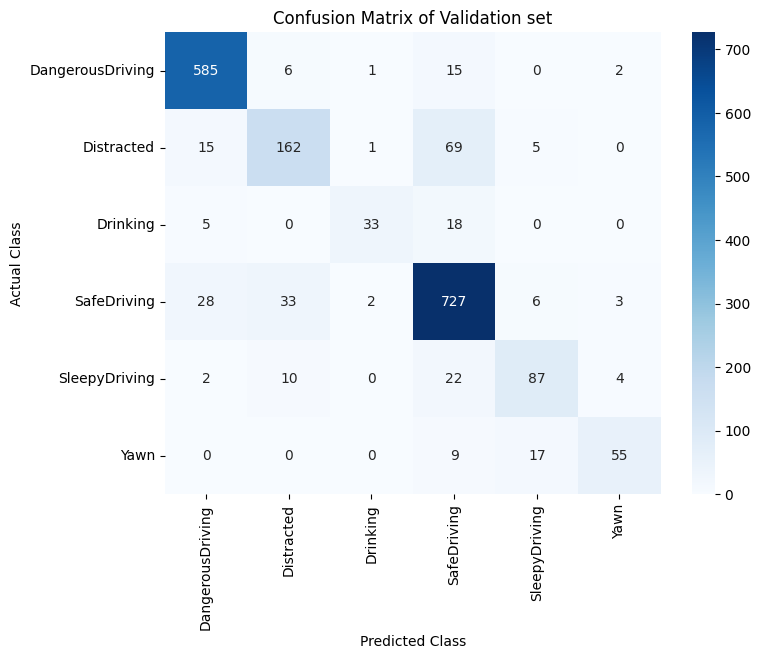

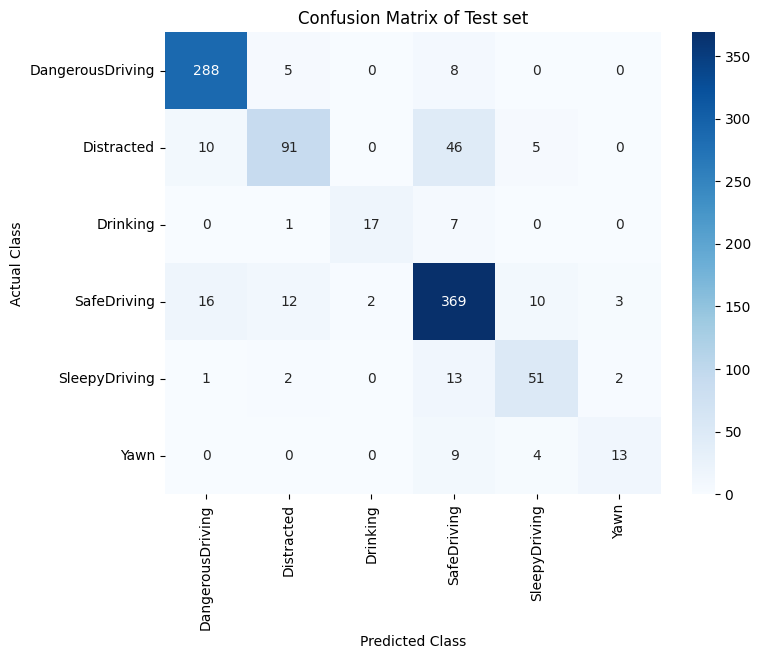

Validation Set Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.92      0.96      0.94       609
      Distracted       0.77      0.64      0.70       252
        Drinking       0.89      0.59      0.71        56
     SafeDriving       0.85      0.91      0.88       799
   SleepyDriving       0.76      0.70      0.72       125
            Yawn       0.86      0.68      0.76        81

        accuracy                           0.86      1922
       macro avg       0.84      0.75      0.79      1922
    weighted avg       0.86      0.86      0.85      1922

Test Set Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.91      0.96      0.94       301
      Distracted       0.82      0.60      0.69       152
        Drinking       0.89      0.68      0.77        25
     SafeDriving       0.82      0.90      0.85       412
   SleepyDriving       0.73      0.74      0.73        6

In [ ]:
#ROC curves and confusion matrices for DenseNet
# Load the best weights
model.load_weights(checkpoint_filepath)

# Plot ROC curve for validation set
y_pred_val = model.predict(val_data)
y_val = val_data.classes
n_classes = len(val_data.class_indices)
y_onehot_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
class_labels = list(val_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Validation set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
y_pred_test = model.predict(test_data)
y_test = test_data.classes
n_classes = len(test_data.class_indices)
y_onehot_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
class_labels = list(test_data.class_indices.keys())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'darkorange', 'deeppink', 'darkgreen', 'aqua','yellow'])
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_labels[i]).plot(ax=plt.gca(), color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test set')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix for validation set
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val  = val_data.classes
cm = confusion_matrix(y_true_val, y_pred_classes_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title('Confusion Matrix of Validation set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot confusion matrix for test set
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix of Test set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Performance measures for validation set
report_val = classification_report(y_true_val, y_pred_classes_val, target_names=list(val_data.class_indices.keys()))
print("Validation Set Classification Report:")
print(report_val)

# Performance measures for test set
report_test = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
print("Test Set Classification Report:")
print(report_test)